# Simulating and visualising the distributions of pgens 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import time
from importlib.resources import files
import math

# --- OLGA Imports ---
# Use a try/except block for robustness in different environments
try:
    import olga
    from olga.load_model import GenerativeModelVDJ
    from olga.generation_probability import GenerationProbabilityVDJ
    from olga.sequence_generation import SequenceGenerationVDJ
    from olga.load_model import GenerativeModelVDJ, GenomicDataVDJ # Re-added for explicit import, though already present above
except ImportError:
    print("Error: The OLGA package is not installed or accessible.")
    sys.exit(1)

# --- Configuration ---
NUM_SEQUENCES = 10000  # Number of sequences to generate
SPECIES = 'human'
CHAIN = 'TRB'

def locate_model_files(species, chain):
    """Locates the necessary model files based on species and chain."""
    if species == 'human' and chain == 'TRB':
        folder_name = "human_T_beta"
    else:
        raise ValueError("Script currently supports only human TRB.")

    try:
        # Standard way to locate files in a package (Python 3.9+)
        model_dir = str(files("olga") / "default_models" / folder_name)
    except Exception:
        # Fallback for older Python versions or unique installs
        import olga as _olga
        model_dir = os.path.join(os.path.dirname(_olga.__file__), "default_models", folder_name)

    if not os.path.exists(model_dir):
        raise FileNotFoundError(f"Model directory not found: {model_dir}")

    def pick_anchor(basename):
        csv_path = os.path.join(model_dir, f"{basename}.csv")
        txt_path = os.path.join(model_dir, f"{basename}.txt")
        if os.path.exists(csv_path): return csv_path
        if os.path.exists(txt_path): return txt_path
        raise FileNotFoundError(f"Anchor file {basename} not found in {model_dir}")

    return {
        'params': os.path.join(model_dir, "model_params.txt"),
        'marginals': os.path.join(model_dir, "model_marginals.txt"),
        'v_anchors': pick_anchor("V_gene_CDR3_anchors"),
        'j_anchors': pick_anchor("J_gene_CDR3_anchors")
    }

def initialize_olga():
    """Initializes and returns the OLGA generation and probability engines."""
    print(f"Initializing OLGA for {SPECIES} {CHAIN}...")
    
    paths = locate_model_files(SPECIES, CHAIN)
    
    # 1. Load Genomic Data
    genomic_data = GenomicDataVDJ()
    genomic_data.load_igor_genomic_data(
        paths['params'], paths['v_anchors'], paths['j_anchors']
    )
    
    # 2. Initialize Generative Model
    model = GenerativeModelVDJ()
    model.load_and_process_igor_model(paths['marginals'])
    
    # 3. Initialize Engines
    gen_prob = GenerationProbabilityVDJ(model, genomic_data)
    seq_gen = SequenceGenerationVDJ(model, genomic_data)
    
    print("OLGA initialization complete.")
    return seq_gen, gen_prob

def run_simulation_and_plot(seq_gen, gen_prob, num_sequences):
    """Generates sequences, calculates Pgen, and plots the distribution."""
    
    sequences = []
    pgens = []
    
    print(f"Generating and evaluating {num_sequences} sequences...")
    
    start_time = time.time()
    
    for i in range(num_sequences):
        try:
            # Generate a random sequence
            item = seq_gen.gen_rnd_prod_CDR3()
            
            # Extract the CDR3 amino acid sequence (index depends on OLGA version)
            cdr3_aa = item[1] if len(item) == 4 else item[0]

            # --- FIX: Robust Pgen Calculation for version compatibility ---
            pgen = 0
            try:
                # Try the most common name (lowercase cdr3)
                pgen = gen_prob.compute_aa_cdr3_pgen(cdr3_aa)
            except AttributeError:
                try:
                    # Try the alternative name (uppercase CDR3)
                    pgen = gen_prob.compute_aa_CDR3_pgen(cdr3_aa)
                except AttributeError:
                    # If both fail, the model object is misconfigured or an older API is needed
                    # Note: We re-raise an error here to stop the script if the function is truly missing
                    raise AttributeError("Pgen function (compute_aa_cdr3_pgen or compute_aa_CDR3_pgen) not found on GenerationProbabilityVDJ object.")
            # --- END FIX ---
            
            if pgen > 0:
                sequences.append(cdr3_aa)
                pgens.append(pgen)
        
        except Exception as e:
            # Catch errors during generation/Pgen calculation for robustness
            print(f"Warning: Failed to process sequence {i}. Error: {e}", file=sys.stderr)
        
        # Progress update
        if (i + 1) % 100 == 0:
            print(f"  Processed {i+1} sequences...")

    end_time = time.time()
    print(f"Completed generation and Pgen calculation in {end_time - start_time:.2f} seconds.")

    # Convert Pgen values to log10 for better visualization
    log_pgens = np.log10(pgens)
    
    # --- Plotting the Distribution ---
    plt.figure(figsize=(10, 6))
    
    # Use a histogram to show the density of states
    n, bins, patches = plt.hist(log_pgens, bins=30, edgecolor='black', color='#3b82f6', alpha=0.8)
    
    # Add mean and median lines
    mean_log_pgen = np.mean(log_pgens)
    median_log_pgen = np.median(log_pgens)

    plt.axvline(mean_log_pgen, color='red', linestyle='dashed', linewidth=2, label=f'Mean (Log10 Pgen: {mean_log_pgen:.2f})')
    plt.axvline(median_log_pgen, color='green', linestyle='dashed', linewidth=2, label=f'Median (Log10 Pgen: {median_log_pgen:.2f})')
    
    # Annotations and Labels
    plt.title(f'Distribution of $\log_{{10}}(P_{{gen}})$ for {len(pgens)} Generated TCR Sequences', fontsize=14)
    plt.xlabel('$\log_{{10}}(P_{{gen}})$', fontsize=12)
    plt.ylabel('Frequency (Number of Sequences)', fontsize=12)
    plt.grid(axis='y', alpha=0.6, linestyle='--')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Create a DataFrame for inspection
    df_results = pd.DataFrame({'cdr3_aa': sequences, 'pgen': pgens, 'log10_pgen': log_pgens})
    
    print("\n--- Summary Statistics ---")
    print(df_results['log10_pgen'].describe())
    
    # Print the modal range (the bin with the highest frequency)
    max_index = np.argmax(n)
    modal_start = bins[max_index]
    modal_end = bins[max_index + 1]
    
    print(f"\nModal Range (The 'Goldilocks Zone'): $\log_{{10}}(P_{{gen}})$ between {modal_start:.2f} and {modal_end:.2f}")
    
    return df_results


Initializing OLGA for human TRB...
OLGA initialization complete.
Generating and evaluating 10000 sequences...
  Processed 100 sequences...
  Processed 200 sequences...
  Processed 300 sequences...
  Processed 400 sequences...
  Processed 500 sequences...
  Processed 600 sequences...
  Processed 700 sequences...
  Processed 800 sequences...
  Processed 900 sequences...
  Processed 1000 sequences...
  Processed 1100 sequences...
  Processed 1200 sequences...
  Processed 1300 sequences...
  Processed 1400 sequences...
  Processed 1500 sequences...
  Processed 1600 sequences...
  Processed 1700 sequences...
  Processed 1800 sequences...
  Processed 1900 sequences...
  Processed 2000 sequences...
  Processed 2100 sequences...
  Processed 2200 sequences...
  Processed 2300 sequences...
  Processed 2400 sequences...
  Processed 2500 sequences...
  Processed 2600 sequences...
  Processed 2700 sequences...
  Processed 2800 sequences...
  Processed 2900 sequences...
  Processed 3000 sequences...

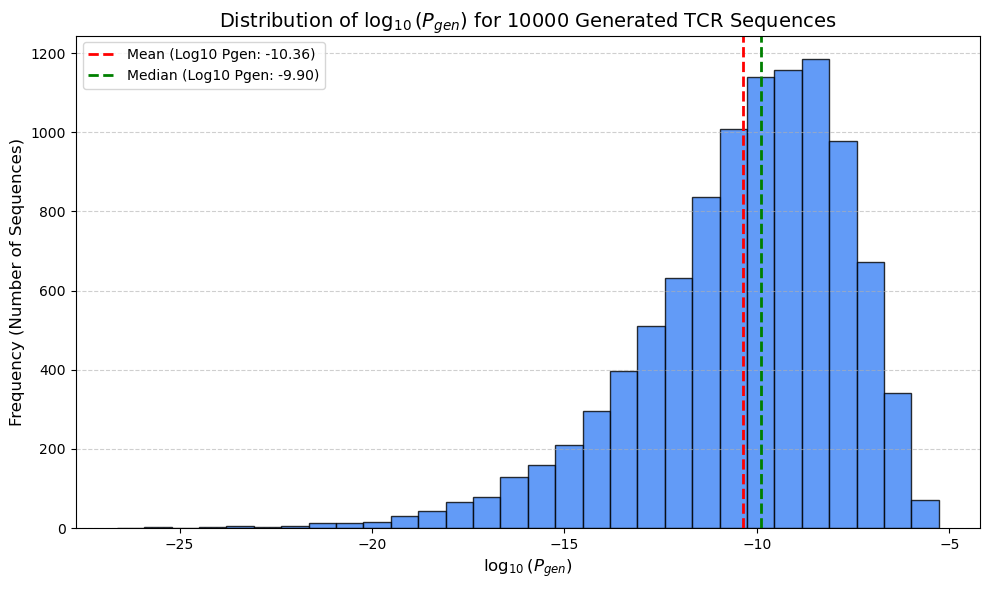


--- Summary Statistics ---
count    10000.000000
mean       -10.355780
std          2.705308
min        -26.629480
25%        -11.798096
50%         -9.895226
75%         -8.389988
max         -5.272577
Name: log10_pgen, dtype: float64

Modal Range (The 'Goldilocks Zone'): $\log_{10}(P_{gen})$ between -8.83 and -8.12


In [3]:

# --- Main Execution Block ---
# This block is what you run in your Jupyter Notebook
if __name__ == '__main__':
    seq_gen, gen_prob = initialize_olga()
    df_sim = run_simulation_and_plot(seq_gen, gen_prob, NUM_SEQUENCES)

# Simualating and visualising V and J usage

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import time
from importlib.resources import files
import math

# --- OLGA Imports ---
try:
    import olga
    from olga.load_model import GenerativeModelVDJ, GenomicDataVDJ
    from olga.generation_probability import GenerationProbabilityVDJ
    from olga.sequence_generation import SequenceGenerationVDJ
except ImportError:
    print("Error: The OLGA package is not installed or accessible.")
    sys.exit(1)

# --- Configuration ---
NUM_SEQUENCES = 203  # Number of sequences to generate
SPECIES = 'human'
CHAIN = 'TRB'

def locate_model_files(species, chain):
    """Locates the necessary model files based on species and chain."""
    if species == 'human' and chain == 'TRB':
        folder_name = "human_T_beta"
    else:
        raise ValueError("Script currently supports only human TRB.")

    try:
        model_dir = str(files("olga") / "default_models" / folder_name)
    except Exception:
        import olga as _olga
        model_dir = os.path.join(os.path.dirname(_olga.__file__), "default_models", folder_name)

    if not os.path.exists(model_dir):
        raise FileNotFoundError(f"Model directory not found: {model_dir}")

    def pick_anchor(basename):
        csv_path = os.path.join(model_dir, f"{basename}.csv")
        txt_path = os.path.join(model_dir, f"{basename}.txt")
        if os.path.exists(csv_path): return csv_path
        if os.path.exists(txt_path): return txt_path
        raise FileNotFoundError(f"Anchor file {basename} not found in {model_dir}")

    return {
        'params': os.path.join(model_dir, "model_params.txt"),
        'marginals': os.path.join(model_dir, "model_marginals.txt"),
        'v_anchors': pick_anchor("V_gene_CDR3_anchors"),
        'j_anchors': pick_anchor("J_gene_CDR3_anchors")
    }

def parse_gene_names(filepath):
    """Parses gene names from OLGA anchor files."""
    names = []
    try:
        with open(filepath, 'r') as f:
            for line in f:
                line = line.strip()
                if not line or line.startswith('#') or line.startswith('gene_name'): continue
                # Handle both CSV and Tab-delimited
                cleaned = line.replace(';', ',').replace('\t', ',')
                parts = cleaned.split(',')
                if parts: 
                    # Clean up name (remove allele *01 if desired, but keeping standard format is good)
                    names.append(parts[0].strip())
    except Exception as e:
        print(f"Warning: Could not parse names from {filepath}: {e}")
    return names

def initialize_olga():
    """Initializes engines and loads gene maps."""
    print(f"Initializing OLGA for {SPECIES} {CHAIN}...")
    
    paths = locate_model_files(SPECIES, CHAIN)
    
    # 1. Load Genomic Data
    genomic_data = GenomicDataVDJ()
    genomic_data.load_igor_genomic_data(
        paths['params'], paths['v_anchors'], paths['j_anchors']
    )
    
    # 2. Parse Gene Names for Plotting
    v_names = parse_gene_names(paths['v_anchors'])
    j_names = parse_gene_names(paths['j_anchors'])
    
    # 3. Initialize Generative Model
    model = GenerativeModelVDJ()
    model.load_and_process_igor_model(paths['marginals'])
    
    # 4. Initialize Engines
    gen_prob = GenerationProbabilityVDJ(model, genomic_data)
    seq_gen = SequenceGenerationVDJ(model, genomic_data)
    
    print(f"OLGA loaded. Found {len(v_names)} V-genes and {len(j_names)} J-genes.")
    return seq_gen, gen_prob, v_names, j_names

def run_simulation_and_visualize(seq_gen, gen_prob, v_names, j_names, num_sequences):
    """Generates sequences, tracks Gene Usage, and visualizes it."""
    
    data_rows = []
    
    print(f"Generating {num_sequences} sequences...")
    start_time = time.time()
    
    for i in range(num_sequences):
        try:
            item = seq_gen.gen_rnd_prod_CDR3()
            
            # Unpack based on OLGA version
            if len(item) == 4:
                _, cdr3_aa, v_idx, j_idx = item
            else:
                cdr3_aa, v_idx, j_idx = item[0], item[1], item[2]

            # Calculate Pgen (optional here, but good for reference)
            pgen = 0
            try:
                pgen = gen_prob.compute_aa_cdr3_pgen(cdr3_aa)
            except AttributeError:
                pgen = gen_prob.compute_aa_CDR3_pgen(cdr3_aa)
            
            # Map Indices to Names
            v_name = v_names[v_idx] if v_idx < len(v_names) else f"V_{v_idx}"
            j_name = j_names[j_idx] if j_idx < len(j_names) else f"J_{j_idx}"

            data_rows.append({
                'cdr3': cdr3_aa,
                'v_idx': v_idx,
                'j_idx': j_idx,
                'v_name': v_name,
                'j_name': j_name,
                'log_pgen': np.log10(pgen) if pgen > 0 else -50
            })
        
        except Exception:
            continue

    df = pd.DataFrame(data_rows)
    print(f"Generation complete. {len(df)} valid sequences.")

    # --- VISUALIZATION ---
    fig = plt.figure(figsize=(15, 12))
    gs = fig.add_gridspec(2, 2)

    # 1. Top 20 V Genes (Bar Chart)
    ax1 = fig.add_subplot(gs[0, 0])
    v_counts = df['v_name'].value_counts().head(20) # Top 20 only
    v_counts.plot(kind='barh', ax=ax1, color='#2563eb', edgecolor='black')
    ax1.set_title(f'Top 20 V-Gene Usage (n={len(df)})')
    ax1.invert_yaxis() # Highest at top
    ax1.set_xlabel('Count')

    # 2. J Gene Usage (Bar Chart)
    ax2 = fig.add_subplot(gs[0, 1])
    j_counts = df['j_name'].value_counts()
    j_counts.plot(kind='bar', ax=ax2, color='#16a34a', edgecolor='black')
    ax2.set_title('J-Gene Usage')
    ax2.set_ylabel('Count')
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

    # 3. V-J Co-occurrence Heatmap
    ax3 = fig.add_subplot(gs[1, :])
    
    # Create pivot table for heatmap
    heatmap_data = pd.crosstab(df['v_name'], df['j_name'])
    
    # Sort by total frequency to make the heatmap ordered
    sorted_v = heatmap_data.sum(axis=1).sort_values(ascending=False).index
    sorted_j = heatmap_data.sum(axis=0).sort_values(ascending=False).index
    heatmap_data = heatmap_data.loc[sorted_v, sorted_j]
    
    # Use imshow for heatmap
    im = ax3.imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
    
    # Add colorbar
    plt.colorbar(im, ax=ax3, label='Frequency')
    
    # Set ticks
    ax3.set_xticks(np.arange(len(heatmap_data.columns)))
    ax3.set_yticks(np.arange(len(heatmap_data.index)))
    
    # Set tick labels
    ax3.set_xticklabels(heatmap_data.columns, rotation=90)
    ax3.set_yticklabels(heatmap_data.index, fontsize=8)
    
    ax3.set_title('V-J Gene Pairing Heatmap (Sorted by Frequency)')
    ax3.set_xlabel('J Gene')
    ax3.set_ylabel('V Gene')

    plt.tight_layout()
    plt.show()

    return df


Initializing OLGA for human TRB...
OLGA loaded. Found 135 V-genes and 16 J-genes.
Generating 203 sequences...
Generation complete. 203 valid sequences.


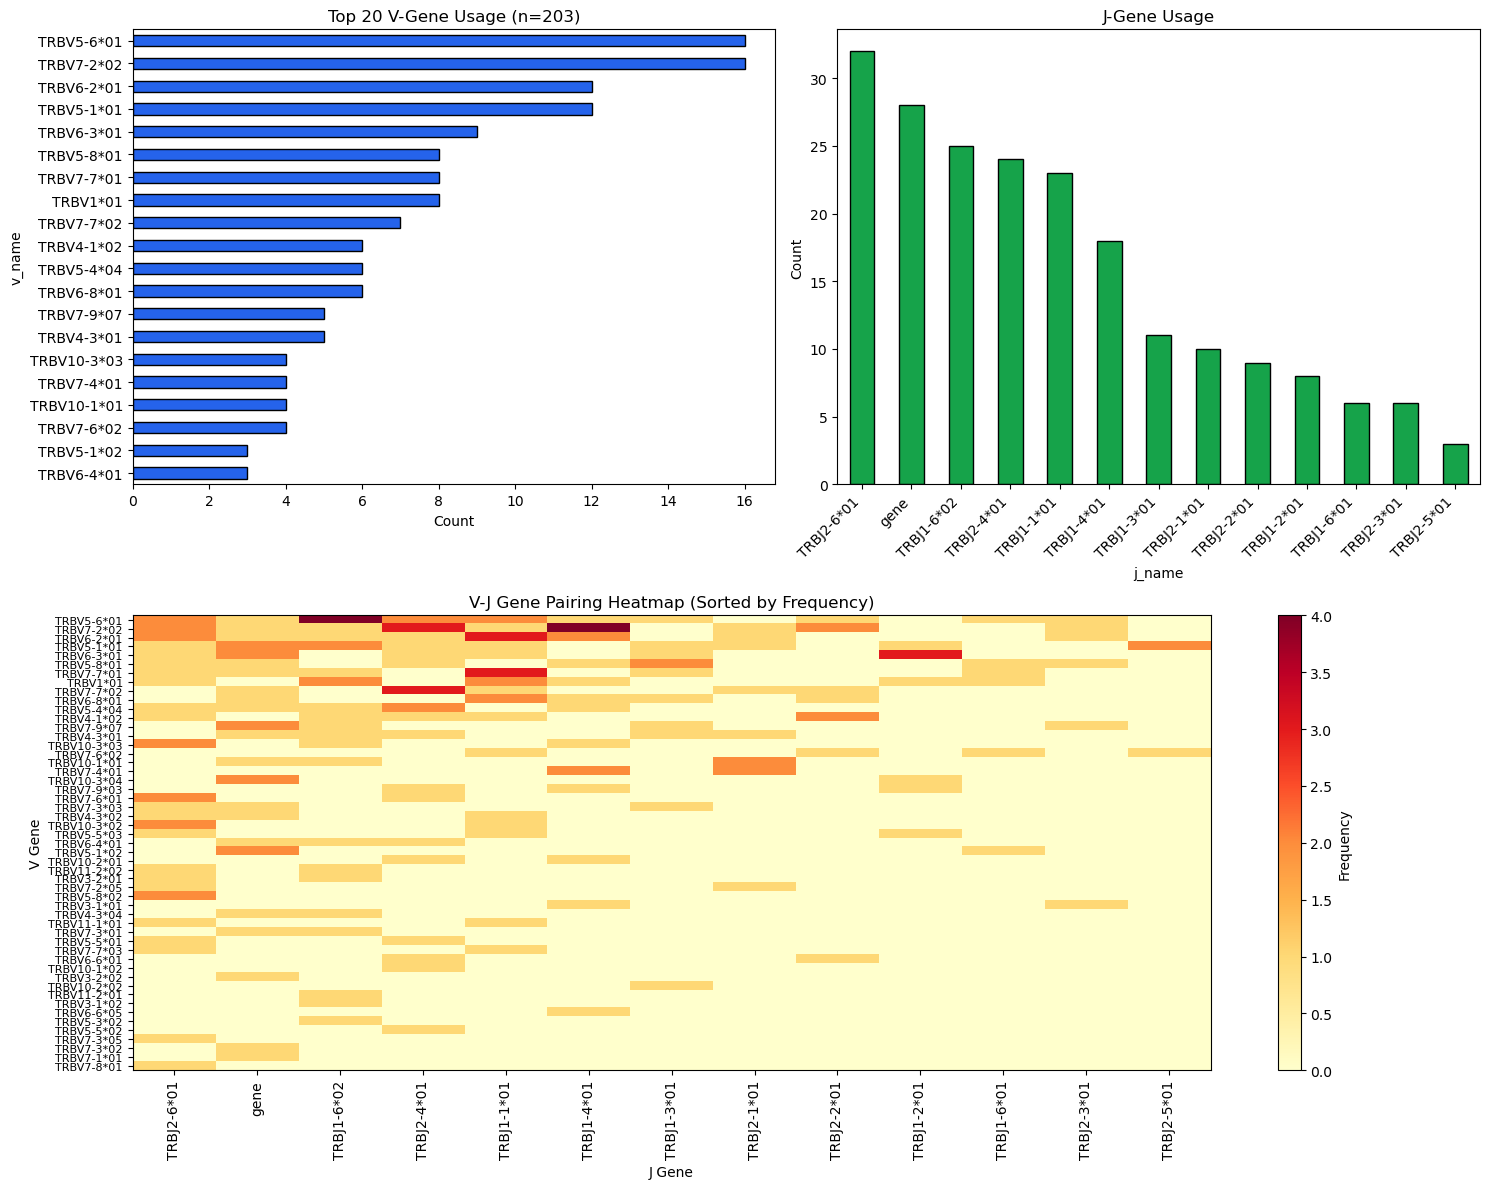

In [7]:
# --- Main Execution Block ---
if __name__ == '__main__':
    seq_gen, gen_prob, v_names, j_names = initialize_olga()
    df_results = run_simulation_and_visualize(seq_gen, gen_prob, v_names, j_names, NUM_SEQUENCES)

# Visualise AC02

In [2]:
INPUT_FILENAME = '/Users/ishaharris/Projects/TCR/clono-scan/data/highconf/AC02.tsv' 

Initializing OLGA for human TRB...
OLGA Model Loaded.
Reading /Users/ishaharris/Projects/TCR/clono-scan/data/highconf/AC04_S1.tsv...
Calculating Pgen for 203 sequences using compute_aa_CDR3_pgen...
Note: This can be slow (~50-100 sequences/sec).
Invalid amino acid CDR3 sequence --- unfamiliar symbol: :2...
Processed 200/203 | Rate: 16.7 seqs/s | Last Pgen: 4.63e-15...
Calculation complete. Valid Pgens found: 202/203


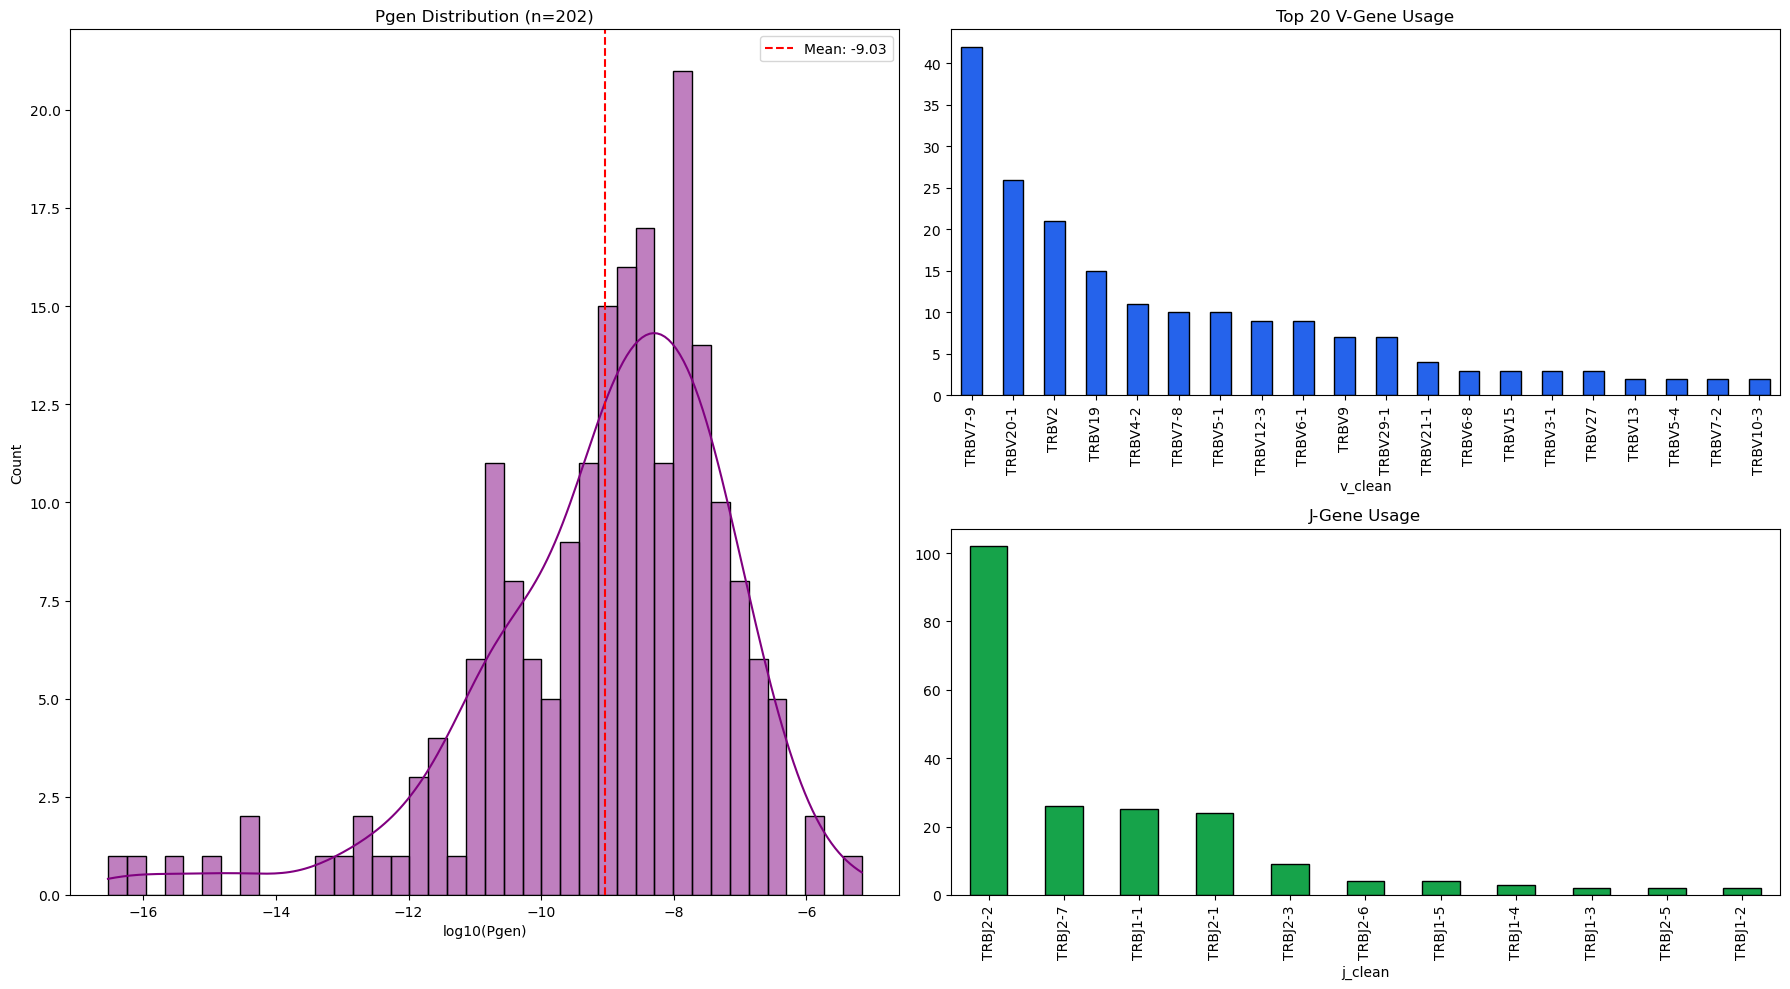

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time
from importlib.resources import files

# --- Configuration ---

highconf = 'AC04_S1.tsv'
INPUT_FILENAME = f'/Users/ishaharris/Projects/TCR/clono-scan/data/highconf/{highconf}' 
SPECIES = 'human'
CHAIN = 'TRB'

# --- Helper Functions ---

def locate_model_files(species, chain):
    """Locates the necessary OLGA model files."""
    if species == 'human' and chain == 'TRB':
        folder_name = "human_T_beta"
    else:
        raise ValueError("Script currently supports only human TRB.")

    try:
        model_dir = str(files("olga") / "default_models" / folder_name)
    except Exception:
        import olga as _olga
        model_dir = os.path.join(os.path.dirname(_olga.__file__), "default_models", folder_name)

    if not os.path.exists(model_dir):
        raise FileNotFoundError(f"Model directory not found: {model_dir}")

    def pick_anchor(basename):
        csv_path = os.path.join(model_dir, f"{basename}.csv")
        txt_path = os.path.join(model_dir, f"{basename}.txt")
        if os.path.exists(csv_path): return csv_path
        if os.path.exists(txt_path): return txt_path
        raise FileNotFoundError(f"Anchor file {basename} not found in {model_dir}")

    return {
        'params': os.path.join(model_dir, "model_params.txt"),
        'marginals': os.path.join(model_dir, "model_marginals.txt"),
        'v_anchors': pick_anchor("V_gene_CDR3_anchors"),
        'j_anchors': pick_anchor("J_gene_CDR3_anchors")
    }

def initialize_olga_engine():
    """Initializes OLGA engines."""
    try:
        import olga
        from olga.load_model import GenerativeModelVDJ, GenomicDataVDJ
        from olga.generation_probability import GenerationProbabilityVDJ
    except ImportError:
        print("Error: 'olga' package not found. Please install via: pip install olga")
        return None

    print(f"Initializing OLGA for {SPECIES} {CHAIN}...")
    paths = locate_model_files(SPECIES, CHAIN)
    
    genomic_data = GenomicDataVDJ()
    genomic_data.load_igor_genomic_data(paths['params'], paths['v_anchors'], paths['j_anchors'])
    
    model = GenerativeModelVDJ()
    model.load_and_process_igor_model(paths['marginals'])
    
    gen_prob = GenerationProbabilityVDJ(model, genomic_data)
    print("OLGA Model Loaded.")
    return gen_prob

def clean_gene_name(gene_str):
    if pd.isna(gene_str): return "Unknown"
    first_gene = str(gene_str).split(',')[0].strip()
    if '*' in first_gene:
        first_gene = first_gene.split('*')[0]
    return first_gene

def run_analysis(filepath, gen_prob):
    if not os.path.exists(filepath):
        print(f"Error: File '{filepath}' not found.")
        return None

    print(f"Reading {filepath}...")
    df = pd.read_csv(filepath, sep='\t')
    
    # Clean Names
    df['v_clean'] = df['v_call'].apply(clean_gene_name)
    df['j_clean'] = df['j_call'].apply(clean_gene_name)

    # --- FIX FOR PGEN METHOD NAME VARIATION ---
    pgen_method = None
    if hasattr(gen_prob, 'compute_aa_CDR3_pgen'): # Try capitalized name (common fix)
        pgen_method = gen_prob.compute_aa_CDR3_pgen
    elif hasattr(gen_prob, 'compute_aa_cdr3_pgen'): # Try lowercase name
        pgen_method = gen_prob.compute_aa_cdr3_pgen
    
    if pgen_method is None:
        print("\nFATAL ERROR: Could not find the required Pgen calculation method ('compute_aa_CDR3_pgen' or 'compute_aa_cdr3_pgen') on the OLGA object. Please check your OLGA package version.")
        return df # Return DF without Pgen calculated
    # ------------------------------------------

    print(f"Calculating Pgen for {len(df)} sequences using {pgen_method.__name__}...")
    print("Note: This can be slow (~50-100 sequences/sec).")
    
    pgens = []
    errors_logged = 0
    
    start_time = time.time()
    
    for i, row in df.iterrows():
        raw_seq = row.get('junction_aa', '')
        
        # 1. Validation & Cleaning
        if pd.isna(raw_seq):
            pgens.append(0)
            continue
            
        # Force uppercase and strip whitespace (Crucial fix)
        seq = str(raw_seq).strip().upper()
        
        # CDR3 must start with C and end with F/W
        # We only check for stop codons/invalid length/unknown residues
        if '*' in seq or 'X' in seq or len(seq) < 3:
            pgens.append(0)
            continue

        # 2. Calculation
        try:
            # Use the dynamically selected method
            p = pgen_method(seq)
            pgens.append(p)
        except Exception as e:
            pgens.append(0)
            # Print the first 3 errors to help debug
            if errors_logged < 3:
                print(f"\n[!] Calculation Error on sequence '{seq}': {e}")
                errors_logged += 1
            
        # 3. Progress Update
        if i > 0 and i % 50 == 0:
            elapsed = time.time() - start_time
            rate = i / elapsed
            print(f"Processed {i}/{len(df)} | Rate: {rate:.1f} seqs/s | Last Pgen: {pgens[-1]:.2e}...", end='\r')

    df['pgen'] = pgens
    # Handle log10 safely (ignoring 0s)
    df['log_pgen'] = df['pgen'].apply(lambda x: np.log10(x) if x > 0 else np.nan)
    
    print(f"\nCalculation complete. Valid Pgens found: {df['pgen'].astype(bool).sum()}/{len(df)}")
    return df

# --- Execution ---

gen_prob_engine = initialize_olga_engine()

if gen_prob_engine:
    df_results = run_analysis(INPUT_FILENAME, gen_prob_engine)

    if df_results is not None:
        valid_pgen = df_results.dropna(subset=['log_pgen'])
        
        if len(valid_pgen) == 0:
            print("\nWARNING: No valid Pgen values were calculated.")
            print("This could be due to: 1. Gene calling discrepancies; 2. All sequences being too rare; 3. Sequence format issues.")
            print("Check that 'junction_aa' sequences start with 'C' and end with 'F' or 'W' as per TCR naming conventions.")
        else:
            plt.figure(figsize=(18, 10))
            
            # Pgen Distribution
            plt.subplot(2, 2, (1, 3))
            sns.histplot(valid_pgen['log_pgen'], bins=40, kde=True, color='purple')
            plt.title(f'Pgen Distribution (n={len(valid_pgen)})')
            plt.xlabel('log10(Pgen)')
            plt.axvline(valid_pgen['log_pgen'].mean(), color='red', linestyle='--', label=f"Mean: {valid_pgen['log_pgen'].mean():.2f}")
            plt.legend()
            
            # V Gene Usage
            plt.subplot(2, 2, 2)
            df_results['v_clean'].value_counts().head(20).plot(kind='bar', color='#2563eb', edgecolor='k')
            plt.title('Top 20 V-Gene Usage')
            
            # J Gene Usage
            plt.subplot(2, 2, 4)
            df_results['j_clean'].value_counts().plot(kind='bar', color='#16a34a', edgecolor='k')
            plt.title('J-Gene Usage')
            
            plt.tight_layout()
            plt.show()

## Compare with random 

In [1]:
from scipy.spatial.distance import jensenshannon
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from importlib.resources import files

# --- Imports specific to OLGA model loading ---
try:
    from olga.load_model import GenerativeModelVDJ, GenomicDataVDJ
    from olga.sequence_generation import SequenceGenerationVDJ
except ImportError:
    raise ImportError("OLGA is not installed. Please install it to run this cell.")

# --- Helper: Re-locate model files ---
def locate_model_files_local(species='human', chain='TRB'):
    if species == 'human' and chain == 'TRB':
        folder_name = "human_T_beta"
    else:
        raise ValueError("Comparison currently supports only human TRB.")

    try:
        model_dir = str(files("olga") / "default_models" / folder_name)
    except Exception:
        import olga as _olga
        model_dir = os.path.join(os.path.dirname(_olga.__file__), "default_models", folder_name)

    if not os.path.exists(model_dir):
        raise FileNotFoundError(f"Model directory not found: {model_dir}")

    def pick_anchor(basename):
        csv_path = os.path.join(model_dir, f"{basename}.csv")
        txt_path = os.path.join(model_dir, f"{basename}.txt")
        if os.path.exists(csv_path): return csv_path
        if os.path.exists(txt_path): return txt_path
        raise FileNotFoundError(f"Anchor file {basename} not found in {model_dir}")

    return {
        'params': os.path.join(model_dir, "model_params.txt"),
        'marginals': os.path.join(model_dir, "model_marginals.txt"),
        'v_anchors': pick_anchor("V_gene_CDR3_anchors"),
        'j_anchors': pick_anchor("J_gene_CDR3_anchors")
    }

# --- Helper: Manual Gene Parsing ---
def parse_gene_names(filepath):
    """Parses gene names from OLGA anchor files."""
    names = []
    try:
        with open(filepath, 'r') as f:
            for line in f:
                line = line.strip()
                if not line or line.startswith('#') or line.startswith('gene_name'): continue
                cleaned = line.replace(';', ',').replace('\t', ',')
                parts = cleaned.split(',')
                if parts: 
                    names.append(parts[0].strip())
    except Exception as e:
        print(f"Warning: Could not parse names from {filepath}: {e}")
    return names

def clean_gene_name(gene_str):
    if pd.isna(gene_str): return "Unknown"
    first_gene = str(gene_str).split(',')[0].strip()
    if '*' in first_gene:
        first_gene = first_gene.split('*')[0]
    return first_gene

def calculate_jsd(dist1, dist2):
    """Calculates Jensen-Shannon Divergence between two Series of categories."""
    all_cats = list(set(dist1.index) | set(dist2.index))
    d1 = dist1.reindex(all_cats, fill_value=0)
    d2 = dist2.reindex(all_cats, fill_value=0)
    p = d1 / d1.sum()
    q = d2 / d2.sum()
    return jensenshannon(p, q)

# --- 1. Setup & Generation ---

# ASSUME: df_results (observed data) and gen_prob_engine (OLGA engine) exist.
df_ac02 = df_results.copy()
N_sequences = 1000

print(f"Generating {N_sequences} random background sequences for comparison...")

# --- INITIALIZATION ---
paths = locate_model_files_local('human', 'TRB')

# 1. Load Genomic Data
genomic_data = GenomicDataVDJ()
genomic_data.load_igor_genomic_data(paths['params'], paths['v_anchors'], paths['j_anchors'])

# 2. Parse Gene Names Manually
v_names = parse_gene_names(paths['v_anchors'])
j_names = parse_gene_names(paths['j_anchors'])

# 3. Load Model
generative_model = GenerativeModelVDJ()
generative_model.load_and_process_igor_model(paths['marginals'])

# 4. Create Sequence Generator
seq_gen = SequenceGenerationVDJ(generative_model, genomic_data)

# Generate Synthetic Data
synthetic_data = []
for _ in range(N_sequences):
    out = seq_gen.gen_rnd_prod_CDR3()
    
    # Unpack based on OLGA version
    if len(out) == 4: _, cdr3, v_idx, j_idx = out
    else: cdr3, v_idx, j_idx = out[0], out[1], out[2]
    
    # Map Indices to Names (Using the manually parsed lists)
    v_name = v_names[v_idx] if v_idx < len(v_names) else f"V_{v_idx}"
    j_name = j_names[j_idx] if j_idx < len(j_names) else f"J_{j_idx}"
    
    # Calculate Pgen for synthetic sequence
    p = 0
    try:
        # Use existing engine to compute pgen
        if hasattr(gen_prob_engine, 'compute_aa_CDR3_pgen'):
            p = gen_prob_engine.compute_aa_CDR3_pgen(cdr3)
        else:
            p = gen_prob_engine.compute_aa_cdr3_pgen(cdr3)
    except:
        pass 
        
    synthetic_data.append({
        'type': 'Random (Background)',
        'log_pgen': np.log10(p) if p > 0 else np.nan,
        'v_clean': clean_gene_name(v_name),
        'j_clean': clean_gene_name(j_name)
    })

df_synth = pd.DataFrame(synthetic_data)
df_ac02['type'] = 'AC02 (Observed)'

# Combine
# FIX: Added ignore_index=True to prevent duplicate indices which cause Seaborn ValueError
df_combined = pd.concat([df_ac02[['type', 'log_pgen', 'v_clean', 'j_clean']], 
                         df_synth[['type', 'log_pgen', 'v_clean', 'j_clean']]],
                         ignore_index=True)

# --- 2. Quantification ---

valid_ac02_pgen = df_ac02['log_pgen'].dropna()
valid_synth_pgen = df_synth['log_pgen'].dropna()

if len(valid_ac02_pgen) == 0 or len(valid_synth_pgen) == 0:
    print("\nWARNING: Not enough valid Pgen values to perform KS Test.")
    ks_stat, p_value = np.nan, np.nan
else:
    ks_stat, p_value = ks_2samp(valid_ac02_pgen, valid_synth_pgen)

jsd_v = calculate_jsd(df_ac02['v_clean'].value_counts(), df_synth['v_clean'].value_counts())
jsd_j = calculate_jsd(df_ac02['j_clean'].value_counts(), df_synth['j_clean'].value_counts())

print(f"--- QUANTIFICATION RESULTS ({N_sequences} Sequences) ---")
print(f"Pgen Distribution Separation (KS Stat): {ks_stat:.4f} (p={p_value:.2e})")
print(f"V-Gene Usage Divergence (JSD):          {jsd_v:.4f}")
print(f"J-Gene Usage Divergence (JSD):          {jsd_j:.4f}")

# --- 3. Visualization ---

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 2)

# Plot 1: Pgen Distribution
ax1 = fig.add_subplot(gs[0, 0])
sns.histplot(data=df_combined, x='log_pgen', hue='type', kde=True, 
             palette={'AC02 (Observed)': 'red', 'Random (Background)': 'gray'}, 
             element="step", fill=False, common_norm=False, ax=ax1)
ax1.set_title(f'Pgen Distribution Comparison\nKS Stat: {ks_stat:.3f}')
ax1.set_xlabel('log10(Pgen)')

# Plot 2: V Gene Usage
ax2 = fig.add_subplot(gs[0, 1])
top_v = df_ac02['v_clean'].value_counts().head(15).index
subset_v = df_combined[df_combined['v_clean'].isin(top_v)]
sns.countplot(data=subset_v, y='v_clean', hue='type', order=top_v, 
              palette={'AC02 (Observed)': 'red', 'Random (Background)': 'gray'}, ax=ax2, alpha=0.8)
ax2.set_title(f'Top 15 V-Gene Usage Comparison\nJSD: {jsd_v:.3f}')
ax2.set_xlabel('Count')

# Plot 3: J Gene Usage
ax3 = fig.add_subplot(gs[1, 0])
top_j = df_ac02['j_clean'].value_counts().head(10).index
subset_j = df_combined[df_combined['j_clean'].isin(top_j)]
sns.countplot(data=subset_j, y='j_clean', hue='type', order=top_j,
              palette={'AC02 (Observed)': 'red', 'Random (Background)': 'gray'}, ax=ax3, alpha=0.8)
ax3.set_title(f'Top 10 J-Gene Usage Comparison\nJSD: {jsd_j:.3f}')
ax3.set_xlabel('Count')

# Plot 4: Summary Boxplot
ax4 = fig.add_subplot(gs[1, 1])
sns.boxplot(data=df_combined, x='type', y='log_pgen', 
            palette={'AC02 (Observed)': 'red', 'Random (Background)': 'gray'}, ax=ax4)
ax4.set_title('Pgen Distribution Summary')

# add a global title
fig.suptitle(f'{highconf} vs random OLGA')

plt.tight_layout()
plt.show()

NameError: name 'df_results' is not defined

/var/folders/ls/vwbn46k51_dbtpbp9vjn8kzh0000gq/T/ipykernel_25463/1266953064.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_combined, x='type', y='log_pgen',


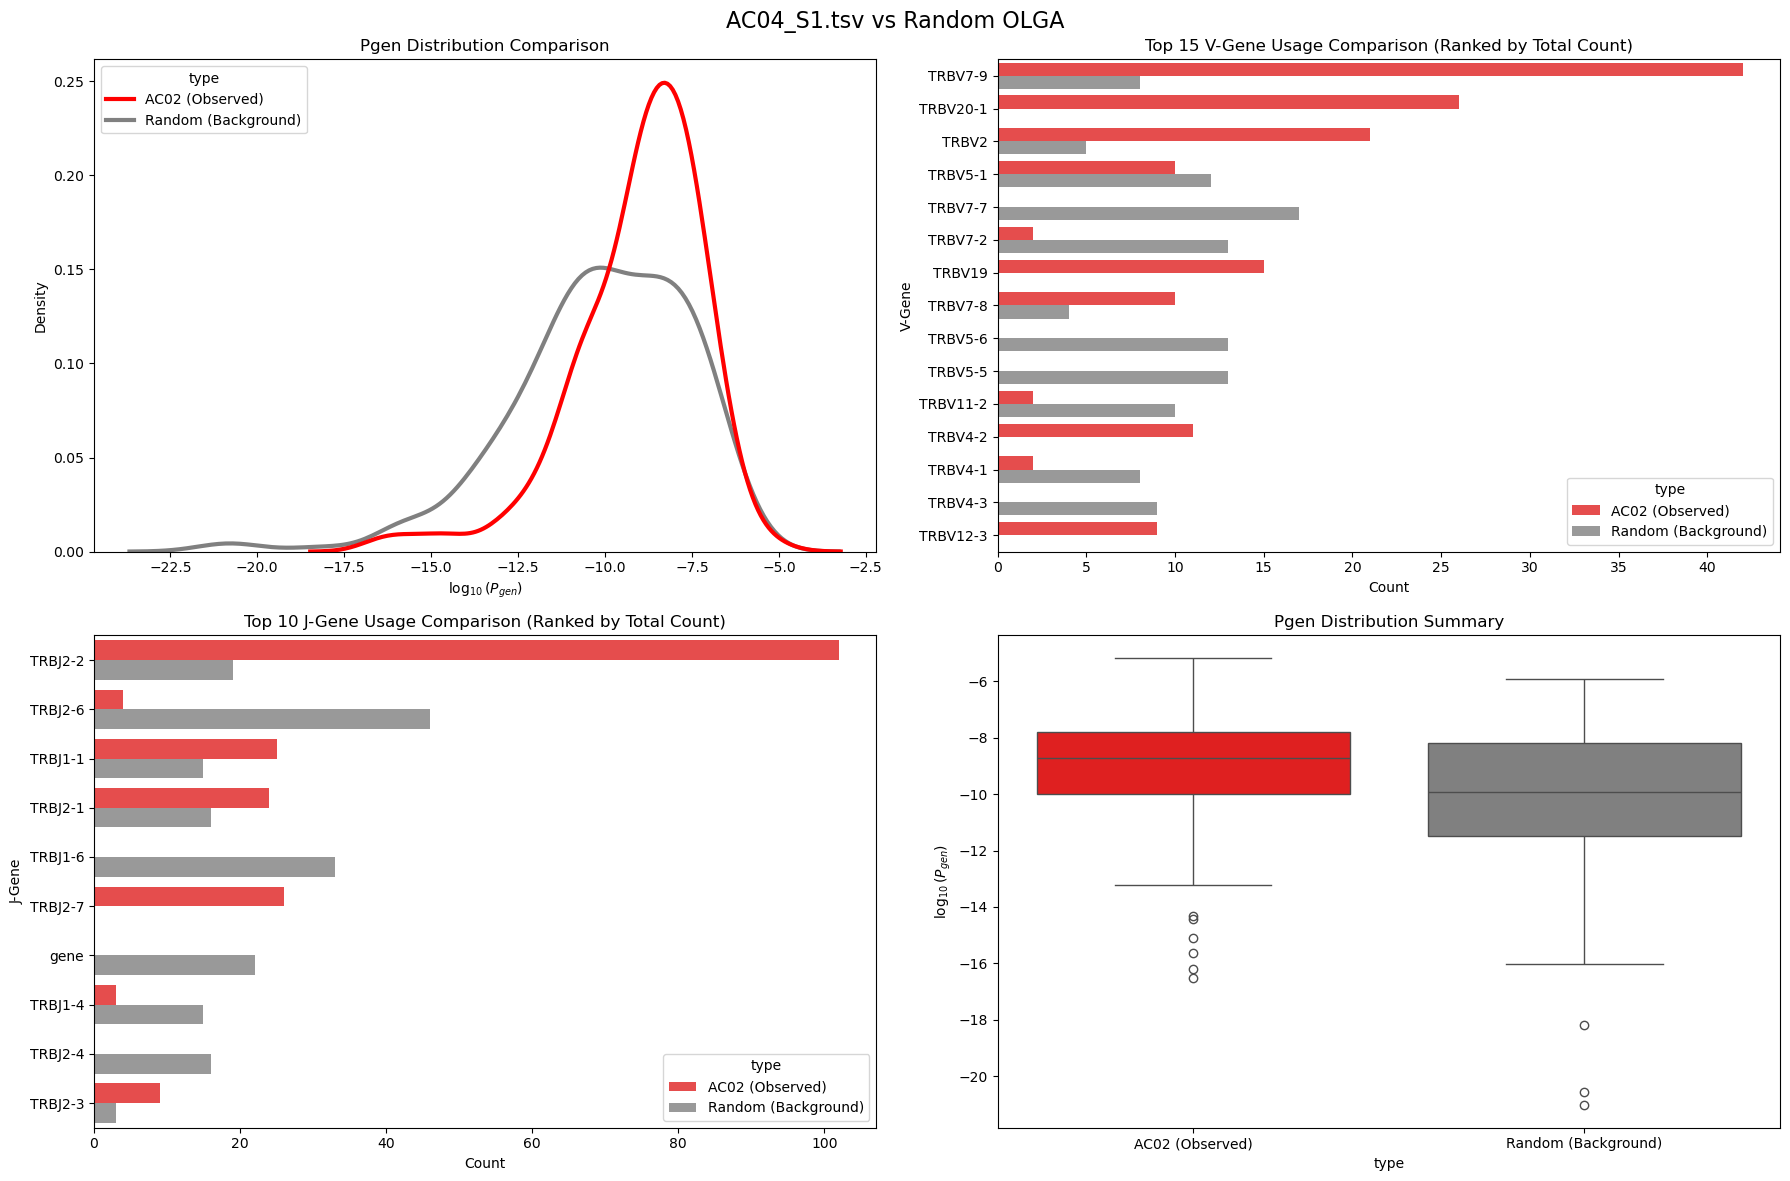

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Import pandas, as it's often needed for data manipulation

# --- 3. Visualization (Modified for KDE Only & Clean Titles) ---

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 2)

# Plot 1: Pgen Distribution (KDE Only, No KS Stat in title)
ax1 = fig.add_subplot(gs[0, 0])
sns.kdeplot(data=df_combined, x='log_pgen', hue='type', 
            palette={'AC02 (Observed)': 'red', 'Random (Background)': 'gray'}, 
            common_norm=False, ax=ax1, linewidth=3)
ax1.set_title('Pgen Distribution Comparison')
ax1.set_xlabel(r'$\log_{10}(P_{gen})$')

# --- PLOT 2 MODIFICATION: V Gene Usage, ranked by total count ---
ax2 = fig.add_subplot(gs[0, 1])

# Calculate the total count (sum of AC02 and Random) for each V-gene
v_counts = df_combined['v_clean'].value_counts() 
v_counts_df = pd.DataFrame(v_counts) # Convert to DataFrame for easier manipulation
v_counts_df.columns = ['Total_Count']

# Get the top 15 V-genes based on the total count
# Note: If df_combined is large, calculating value_counts on it is sufficient 
# to get the total burden across both types.
top_v_by_total = v_counts_df.sort_values(by='Total_Count', ascending=False).head(15).index

# Subset the data to only include the top 15 genes
subset_v = df_combined[df_combined['v_clean'].isin(top_v_by_total)]

# Plot using the new, total-count based order
sns.countplot(data=subset_v, y='v_clean', hue='type', order=top_v_by_total, 
              palette={'AC02 (Observed)': 'red', 'Random (Background)': 'gray'}, ax=ax2, alpha=0.8)
ax2.set_title('Top 15 V-Gene Usage Comparison (Ranked by Total Count)')
ax2.set_xlabel('Count')
ax2.set_ylabel('V-Gene')

# --- PLOT 3 MODIFICATION: J Gene Usage, ranked by total count ---
ax3 = fig.add_subplot(gs[1, 0])

# Calculate the total count (sum of AC02 and Random) for each J-gene
j_counts = df_combined['j_clean'].value_counts()
j_counts_df = pd.DataFrame(j_counts)
j_counts_df.columns = ['Total_Count']

# Get the top 10 J-genes based on the total count
top_j_by_total = j_counts_df.sort_values(by='Total_Count', ascending=False).head(10).index

# Subset the data to only include the top 10 genes
subset_j = df_combined[df_combined['j_clean'].isin(top_j_by_total)]

# Plot using the new, total-count based order
sns.countplot(data=subset_j, y='j_clean', hue='type', order=top_j_by_total,
              palette={'AC02 (Observed)': 'red', 'Random (Background)': 'gray'}, ax=ax3, alpha=0.8)
ax3.set_title('Top 10 J-Gene Usage Comparison (Ranked by Total Count)')
ax3.set_xlabel('Count')
ax3.set_ylabel('J-Gene')

# Plot 4: Summary Boxplot
ax4 = fig.add_subplot(gs[1, 1])
sns.boxplot(data=df_combined, x='type', y='log_pgen', 
            palette={'AC02 (Observed)': 'red', 'Random (Background)': 'gray'}, ax=ax4)
ax4.set_title('Pgen Distribution Summary')
ax4.set_ylabel(r'$\log_{10}(P_{gen})$')

# add a global title
fig.suptitle(f'{highconf} vs Random OLGA', fontsize=16)

plt.tight_layout()
plt.show()

# Dual probability of V and J genes

In [2]:
from scipy.spatial.distance import jensenshannon
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from importlib.resources import files

# --- Imports specific to OLGA model loading ---
try:
    from olga.load_model import GenerativeModelVDJ, GenomicDataVDJ
    from olga.sequence_generation import SequenceGenerationVDJ
except ImportError:
    raise ImportError("OLGA is not installed. Please install it to run this cell.")

# --- Helper: Re-locate model files ---
def locate_model_files_local(species='human', chain='TRB'):
    if species == 'human' and chain == 'TRB':
        folder_name = "human_T_beta"
    else:
        raise ValueError("Comparison currently supports only human TRB.")

    try:
        model_dir = str(files("olga") / "default_models" / folder_name)
    except Exception:
        import olga as _olga
        model_dir = os.path.join(os.path.dirname(_olga.__file__), "default_models", folder_name)

    if not os.path.exists(model_dir):
        raise FileNotFoundError(f"Model directory not found: {model_dir}")

    def pick_anchor(basename):
        csv_path = os.path.join(model_dir, f"{basename}.csv")
        txt_path = os.path.join(model_dir, f"{basename}.txt")
        if os.path.exists(csv_path): return csv_path
        if os.path.exists(txt_path): return txt_path
        raise FileNotFoundError(f"Anchor file {basename} not found in {model_dir}")

    return {
        'params': os.path.join(model_dir, "model_params.txt"),
        'marginals': os.path.join(model_dir, "model_marginals.txt"),
        'v_anchors': pick_anchor("V_gene_CDR3_anchors"),
        'j_anchors': pick_anchor("J_gene_CDR3_anchors")
    }

# --- Helper: Parsing ---
def parse_gene_names(filepath):
    names = []
    try:
        with open(filepath, 'r') as f:
            for line in f:
                line = line.strip()
                if not line or line.startswith('#') or line.startswith('gene_name'): continue
                cleaned = line.replace(';', ',').replace('\t', ',')
                parts = cleaned.split(',')
                if parts: 
                    names.append(parts[0].strip())
    except Exception as e:
        print(f"Warning: Could not parse names from {filepath}: {e}")
    return names

def clean_gene_name(gene_str):
    if pd.isna(gene_str): return "Unknown"
    first_gene = str(gene_str).split(',')[0].strip()
    if '*' in first_gene:
        first_gene = first_gene.split('*')[0]
    return first_gene

def calculate_jsd(dist1, dist2):
    """Calculates Jensen-Shannon Divergence between two Series of categories."""
    # Union of all categories found in either set
    all_cats = list(set(dist1.index) | set(dist2.index))
    d1 = dist1.reindex(all_cats, fill_value=0)
    d2 = dist2.reindex(all_cats, fill_value=0)
    # Normalize to probabilities
    p = d1 / d1.sum()
    q = d2 / d2.sum()
    return jensenshannon(p, q)

# --- 1. Setup & Generation ---

# ASSUME: df_results (observed data) and gen_prob_engine (OLGA engine) exist.
df_ac02 = df_results.copy()

# USER CONFIG: Set number of sequences to generate
# Using len(df_ac02) * 5 is usually good for statistical stability, 
# but you can set a fixed number like 1000 or 10000.
N_sequences = 50000  

print(f"Generating {N_sequences} random background sequences for comparison...")

# Initialize Model
paths = locate_model_files_local('human', 'TRB')
genomic_data = GenomicDataVDJ()
genomic_data.load_igor_genomic_data(paths['params'], paths['v_anchors'], paths['j_anchors'])
v_names = parse_gene_names(paths['v_anchors'])
j_names = parse_gene_names(paths['j_anchors'])
generative_model = GenerativeModelVDJ()
generative_model.load_and_process_igor_model(paths['marginals'])
seq_gen = SequenceGenerationVDJ(generative_model, genomic_data)

# Generate
synthetic_data = []
for _ in range(N_sequences):
    out = seq_gen.gen_rnd_prod_CDR3()
    
    if len(out) == 4: _, cdr3, v_idx, j_idx = out
    else: cdr3, v_idx, j_idx = out[0], out[1], out[2]
    
    v_name = v_names[v_idx] if v_idx < len(v_names) else f"V_{v_idx}"
    j_name = j_names[j_idx] if j_idx < len(j_names) else f"J_{j_idx}"
    
    # Calculate Pgen
    p = 0
    try:
        if hasattr(gen_prob_engine, 'compute_aa_CDR3_pgen'):
            p = gen_prob_engine.compute_aa_CDR3_pgen(cdr3)
        else:
            p = gen_prob_engine.compute_aa_cdr3_pgen(cdr3)
    except:
        pass 
        
    synthetic_data.append({
        'type': 'Random (Background)',
        'log_pgen': np.log10(p) if p > 0 else np.nan,
        'v_clean': clean_gene_name(v_name),
        'j_clean': clean_gene_name(j_name)
    })

df_synth = pd.DataFrame(synthetic_data)
df_ac02['type'] = 'AC02 (Observed)'

# --- 2. Create Joint V-J Columns ---

df_ac02['vj_clean'] = df_ac02['v_clean'] + "_" + df_ac02['j_clean']
df_synth['vj_clean'] = df_synth['v_clean'] + "_" + df_synth['j_clean']

# Combine Dataframes
df_combined = pd.concat([df_ac02[['type', 'log_pgen', 'v_clean', 'j_clean', 'vj_clean']], 
                         df_synth[['type', 'log_pgen', 'v_clean', 'j_clean', 'vj_clean']]],
                         ignore_index=True)

# --- 3. Profile the Bottleneck (Quantification) ---

# 1. Pgen Stats
valid_ac02_pgen = df_ac02['log_pgen'].dropna()
valid_synth_pgen = df_synth['log_pgen'].dropna()
ks_stat, p_value = ks_2samp(valid_ac02_pgen, valid_synth_pgen)

# 2. Gene Usage Bottlenecks (JSD)
jsd_v = calculate_jsd(df_ac02['v_clean'].value_counts(), df_synth['v_clean'].value_counts())
jsd_j = calculate_jsd(df_ac02['j_clean'].value_counts(), df_synth['j_clean'].value_counts())
jsd_vj = calculate_jsd(df_ac02['vj_clean'].value_counts(), df_synth['vj_clean'].value_counts())

print("\n" + "="*40)
print("       BOTTLENECK DIAGNOSIS       ")
print("="*40)
print(f"1. V-Gene Divergence: {jsd_v:.4f}")
print(f"2. J-Gene Divergence: {jsd_j:.4f}")
print(f"3. V-J Pairing Divergence: {jsd_vj:.4f}")
print("-" * 40)

# Diagnosis Logic
diff_vj_v = jsd_vj - jsd_v
diff_vj_j = jsd_vj - jsd_j
bottleneck = "Unknown"

if jsd_v > jsd_j and jsd_v > 0.3:
    bottleneck = "V-Gene Availability"
    print(">> DIAGNOSIS: The mismatch is primarily driven by V-GENE selection.")
elif jsd_j > jsd_v and jsd_j > 0.3:
    bottleneck = "J-Gene Availability"
    print(">> DIAGNOSIS: The mismatch is primarily driven by J-GENE selection.")
elif jsd_vj > (max(jsd_v, jsd_j) + 0.1):
    bottleneck = "Specific V-J Combinations"
    print(">> DIAGNOSIS: The mismatch is driven by specific V-J PAIRINGS (Combinatorial constraint).")
    print("   (The joint error is significantly higher than marginal errors)")
else:
    print(">> DIAGNOSIS: Errors are distributed; likely general sequence composition or low N.")

print(f"KS Stat (Pgen): {ks_stat:.4f} (p={p_value:.2e})")

# --- 4. Advanced Visualization (Normalized by Frequency) ---

def get_normalized_gene_usage(df, gene_col, group_col='type'):
    """
    Calculates the frequency (0-1) of each gene within its group.
    Returns:
      1. A long-form DataFrame for plotting.
      2. A list of genes sorted by sum of frequencies (equal weight sorting).
    """
    # 1. Count occurrences
    counts = df.groupby([group_col, gene_col]).size().reset_index(name='count')
    
    # 2. Normalize by total sequences in that group
    #    (e.g., count / 203 for AC02, count / 1000 for Random)
    group_totals = counts.groupby(group_col)['count'].transform('sum')
    counts['frequency'] = counts['count'] / group_totals
    
    # 3. Determine Sort Order (Sum of Frequencies)
    #    Pivot to get [Gene x Type] matrix
    pivot = counts.pivot(index=gene_col, columns=group_col, values='frequency').fillna(0)
    pivot['total_weight'] = pivot.sum(axis=1) # Sums freq_obs + freq_rnd
    sorted_genes = pivot.sort_values('total_weight', ascending=False).index.tolist()
    
    return counts, sorted_genes

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 3) 

# Plot 1: Pgen Distribution (Already normalized by density/frequency via kde/hist options)
ax1 = fig.add_subplot(gs[0, 0])
# Note: stat="density" or common_norm=False helps normalize histograms
sns.histplot(data=df_combined, x='log_pgen', hue='type', kde=True, 
             palette={'AC02 (Observed)': 'red', 'Random (Background)': 'gray'}, 
             element="step", fill=False, stat='density', common_norm=False, ax=ax1)
ax1.set_title(f'Pgen Density Comparison\nKS: {ks_stat:.3f}')
ax1.set_ylabel('Density')

# Plot 2: V Gene Usage (Normalized)
ax2 = fig.add_subplot(gs[0, 1])
v_counts, v_order = get_normalized_gene_usage(df_combined, 'v_clean')

# Filter for top 20 genes based on the normalized sort order
top_v_genes = v_order[:20]
v_plot_data = v_counts[v_counts['v_clean'].isin(top_v_genes)]

sns.barplot(data=v_plot_data, y='v_clean', x='frequency', hue='type', order=top_v_genes,
            palette={'AC02 (Observed)': 'red', 'Random (Background)': 'gray'}, 
            ax=ax2, alpha=0.8, edgecolor='black', linewidth=0.5)

ax2.set_title(f'Top 20 V-Genes (Normalized Frequency)\nJSD(V): {jsd_v:.3f}')
ax2.set_xlabel('Frequency (Proportion of Repertoire)')
ax2.set_ylabel('')

# Plot 3: J Gene Usage (Normalized)
ax3 = fig.add_subplot(gs[0, 2])
j_counts, j_order = get_normalized_gene_usage(df_combined, 'j_clean')

# Filter for top 15 genes
top_j_genes = j_order[:15]
j_plot_data = j_counts[j_counts['j_clean'].isin(top_j_genes)]

sns.barplot(data=j_plot_data, y='j_clean', x='frequency', hue='type', order=top_j_genes,
            palette={'AC02 (Observed)': 'red', 'Random (Background)': 'gray'}, 
            ax=ax3, alpha=0.8, edgecolor='black', linewidth=0.5)

ax3.set_title(f'Top 15 J-Genes (Normalized Frequency)\nJSD(J): {jsd_j:.3f}')
ax3.set_xlabel('Frequency (Proportion of Repertoire)')
ax3.set_ylabel('')

# Plot 4: V-J Difference Heatmap (Already Normalized in logic)
ax4 = fig.add_subplot(gs[1, :]) 

# 1. Frequency Matrix AC02
obs_counts = df_ac02.groupby(['v_clean', 'j_clean']).size().unstack(fill_value=0)
obs_freq = obs_counts / obs_counts.sum().sum() # This normalizes to 1.0

# 2. Frequency Matrix Synthetic
gen_counts = df_synth.groupby(['v_clean', 'j_clean']).size().unstack(fill_value=0)
gen_freq = gen_counts / gen_counts.sum().sum() # This normalizes to 1.0

# 3. Align indices
all_vs = sorted(list(set(obs_freq.index) | set(gen_freq.index)))
all_js = sorted(list(set(obs_freq.columns) | set(gen_freq.columns)))

obs_freq = obs_freq.reindex(index=all_vs, columns=all_js, fill_value=0)
gen_freq = gen_freq.reindex(index=all_vs, columns=all_js, fill_value=0)

# 4. Difference
diff_matrix = obs_freq - gen_freq

# Filter: Only show genes that appear > 0.5% in EITHER dataset (Normalized threshold)
sig_vs = [v for v in all_vs if (obs_freq.loc[v].max() > 0.005 or gen_freq.loc[v].max() > 0.005)]
sig_js = [j for j in all_js if (obs_freq[j].max() > 0.005 or gen_freq[j].max() > 0.005)]

diff_matrix_trim = diff_matrix.loc[sig_vs, sig_js]

sns.heatmap(diff_matrix_trim, cmap='vlag', center=0, ax=ax4, cbar_kws={'label': 'Freq Diff (Obs - Model)'})
ax4.set_title(f'V-J Bottleneck Heatmap (Difference in Frequencies)\nJoint Divergence JSD(VJ): {jsd_vj:.3f}')

plt.suptitle(f"OLGA Mismatch Analysis (Normalized): {bottleneck}")
plt.tight_layout()
plt.show()

NameError: name 'df_results' is not defined

# Apparently a set theory audit of why it doesn't work??? thanks gemini

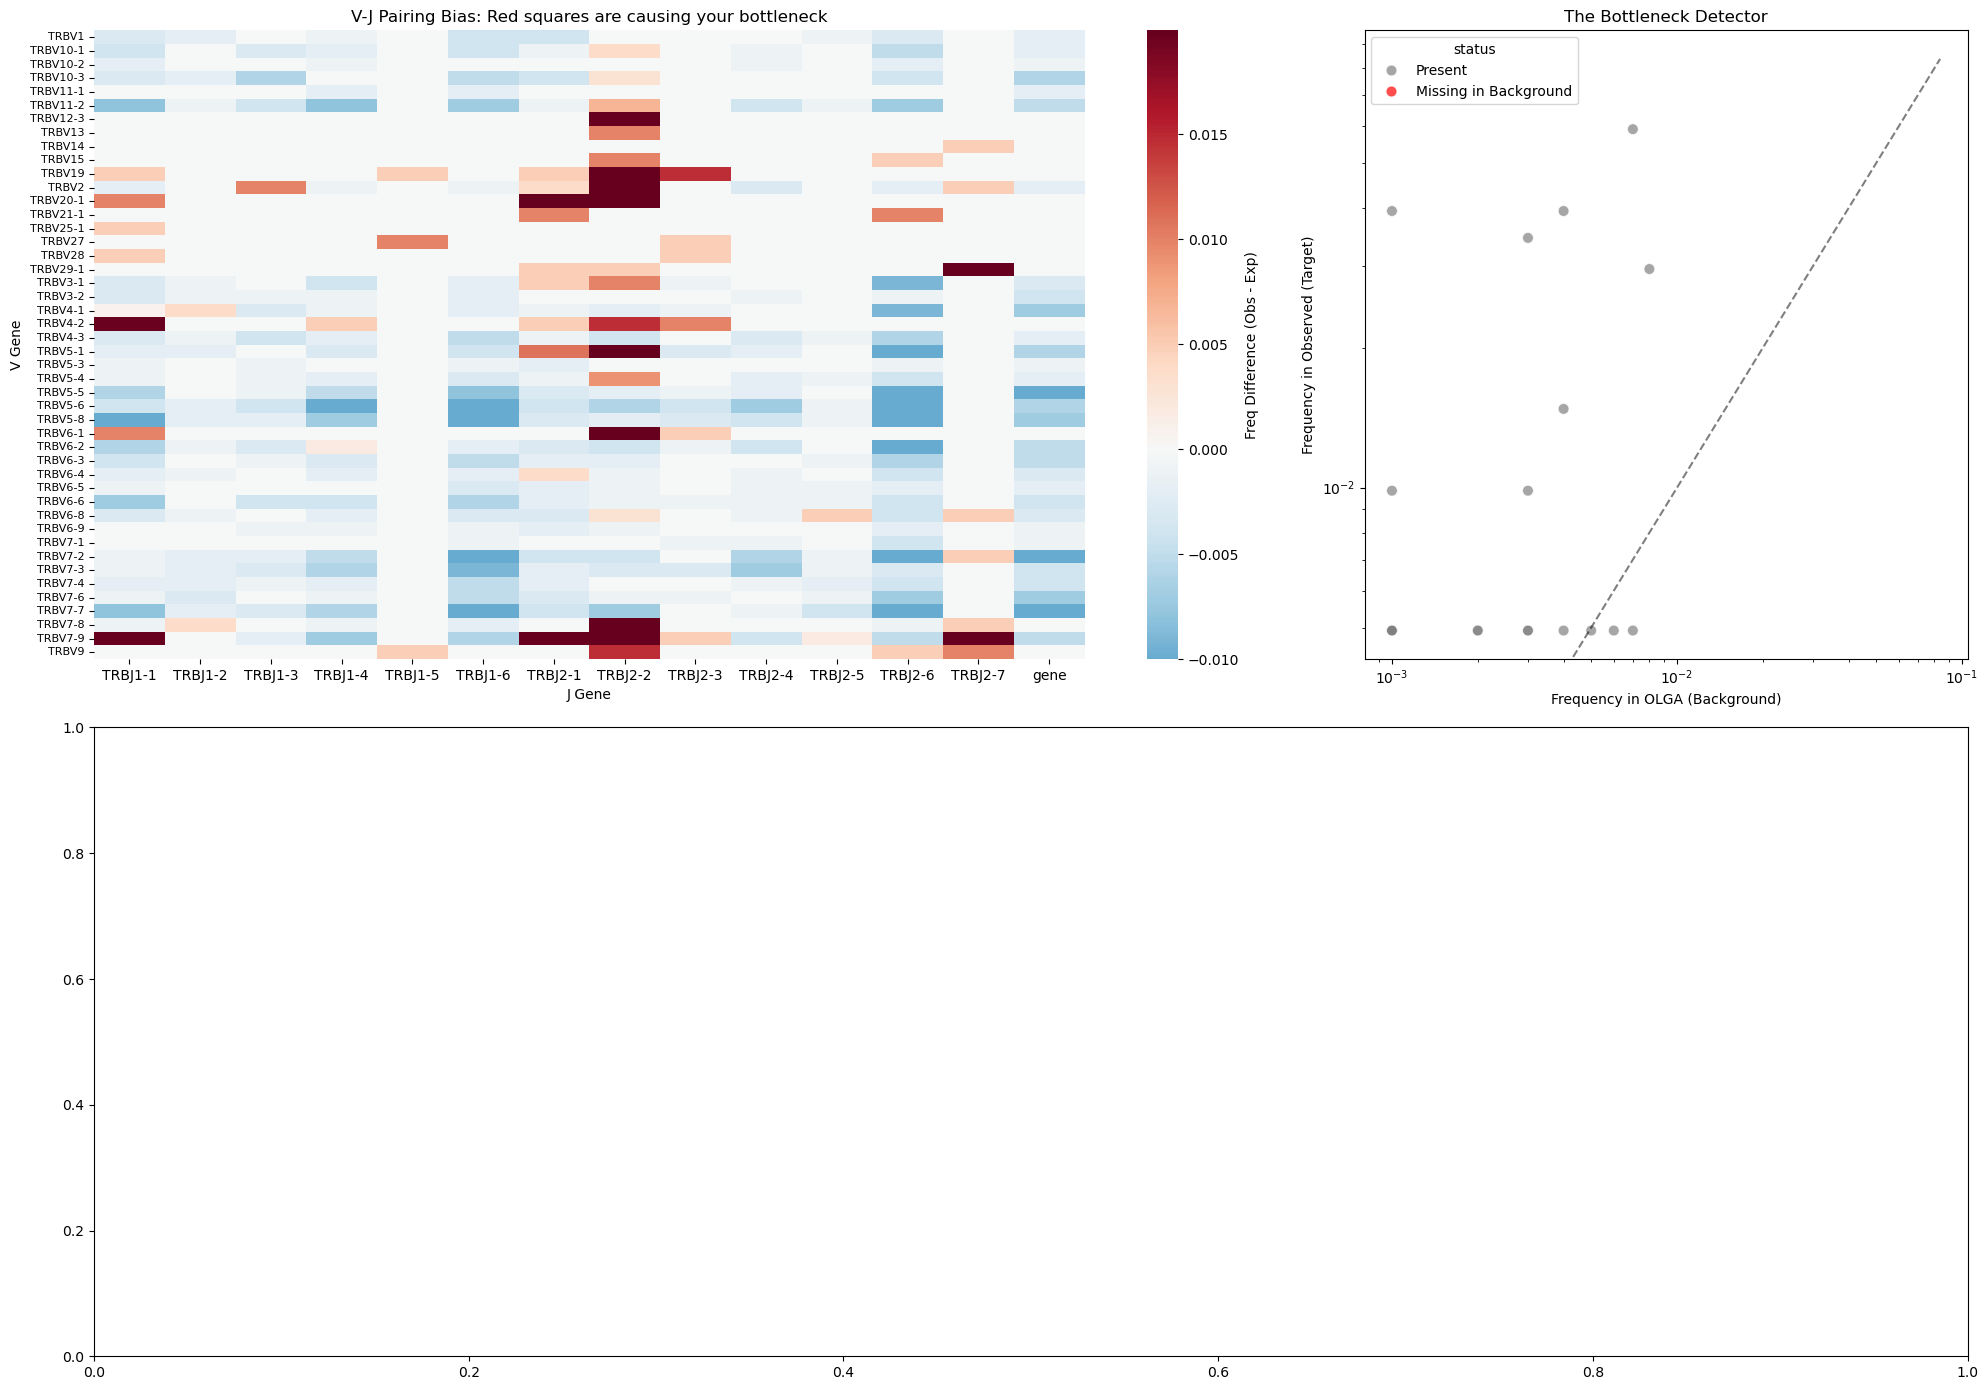

--- BOTTLENECK REPORT ---
Total Unique V-J Pairs in Observed Data: 67
Pairs present in Observed but NEVER seen in Background simulation: 46

Top 5 'Impossible' Pairs (High Obs Freq, 0 Background Freq):
            v        j  obs_freq
60      TRBV2  TRBJ2-2  0.083744
67   TRBV20-1  TRBJ2-2  0.083744
327   TRBV7-9  TRBJ2-7  0.068966
45   TRBV12-3  TRBJ2-2  0.044335
53     TRBV19  TRBJ2-2  0.044335


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- PRE-PROCESSING: Normalize frequencies for fair comparison ---

# 1. Create a crosstab (matrix) for Observed and Background V-J usage
# We use 'normalize=True' to get probabilities instead of raw counts
observed_matrix = pd.crosstab(
    df_combined[df_combined['type'].str.contains('Observed')]['v_clean'], 
    df_combined[df_combined['type'].str.contains('Observed')]['j_clean'],
    normalize='all'
)

background_matrix = pd.crosstab(
    df_combined[df_combined['type'].str.contains('Random')]['v_clean'], 
    df_combined[df_combined['type'].str.contains('Random')]['j_clean'],
    normalize='all'
)

# 2. Align the matrices (ensure they have same columns/rows, fill missing with 0)
# This is crucial because your observed data might have V-genes not found in the small random sample
all_v = sorted(set(observed_matrix.index) | set(background_matrix.index))
all_j = sorted(set(observed_matrix.columns) | set(background_matrix.columns))

observed_matrix = observed_matrix.reindex(index=all_v, columns=all_j, fill_value=0)
background_matrix = background_matrix.reindex(index=all_v, columns=all_j, fill_value=0)

# 3. Calculate Difference (Observed - Background)
# Positive (Red) = Enriched in your data (Hard to generate)
# Negative (Blue) = Common in OLGA, rare in your data
diff_matrix = observed_matrix - background_matrix

# --- VISUALIZATION EXPANSION ---

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(2, 3) 

# --- PLOT 5: Differential V-J Usage Heatmap ---
# --- PLOT 5: Differential V-J Usage Heatmap ---
ax5 = fig.add_subplot(gs[0, :2]) # Span 2 columns
sns.heatmap(diff_matrix, cmap='RdBu_r', center=0, ax=ax5, robust=True, cbar_kws={'label': 'Freq Difference (Obs - Exp)'})
ax5.set_title('V-J Pairing Bias: Red squares are causing your bottleneck')
ax5.set_ylabel('V Gene')
ax5.set_xlabel('J Gene')

# --- Start of Modification to Label Every Row ---
# Get the row labels (V Genes)
v_genes = diff_matrix.index.tolist()
# Set the tick positions (0.5, 1.5, 2.5, ...)
ax5.set_yticks(np.arange(len(v_genes)) + 0.5)
# Set the labels corresponding to the positions
ax5.set_yticklabels(v_genes, rotation=0, fontsize=8) # Lower fontsize if there are many V-genes
# --- End of Modification ---

# --- PLOT 6: The "Starvation" Scatter Plot ---
# Compares Frequency of every V-J pair in Observed vs Background
ax6 = fig.add_subplot(gs[0, 2])

# Flatten matrices to lists for plotting
vj_pairs = []
for v in all_v:
    for j in all_j:
        obs_freq = observed_matrix.loc[v, j]
        bg_freq = background_matrix.loc[v, j]
        if obs_freq > 0 or bg_freq > 0: # Only plot if it exists somewhere
            vj_pairs.append({
                'v': v, 'j': j, 
                'obs_freq': obs_freq, 
                'bg_freq': bg_freq,
                'status': 'Missing in Background' if bg_freq == 0 else 'Present'
            })

df_scatter = pd.DataFrame(vj_pairs)

# Plot
sns.scatterplot(data=df_scatter, x='bg_freq', y='obs_freq', hue='status', 
                palette={'Missing in Background': 'red', 'Present': 'grey'}, 
                ax=ax6, s=60, alpha=0.7)

# Add y=x line (Ideal correlation)
max_val = max(df_scatter['obs_freq'].max(), df_scatter['bg_freq'].max())
ax6.plot([0, max_val], [0, max_val], 'k--', alpha=0.5)

ax6.set_title('The Bottleneck Detector')
ax6.set_xlabel('Frequency in OLGA (Background)')
ax6.set_ylabel('Frequency in Observed (Target)')
ax6.set_yscale('log')
ax6.set_xscale('log')

# --- PLOT 7: CDR3 Length Distribution ---
# Sometimes the VJ fits, but the Length is weird
ax7 = fig.add_subplot(gs[1, :])

# Calculate lengths if not already present
if 'length' not in df_combined.columns:
    # Assuming you have a 'cdr3_aa' or 'junction_aa' column. Adjust name as needed.
    # If strictly Pgen analysis, you might skip this, but it's usually the 3rd variable in Pgen
    pass 
else:
    sns.kdeplot(data=df_combined, x='length', hue='type', 
                palette={'AC02 (Observed)': 'red', 'Random (Background)': 'gray'}, 
                fill=True, common_norm=False, ax=ax7)
    ax7.set_title('CDR3 Length Distribution Mismatch')

plt.tight_layout()
plt.show()

# --- DIAGNOSTIC REPORT ---
print("--- BOTTLENECK REPORT ---")
missing = df_scatter[df_scatter['bg_freq'] == 0]
print(f"Total Unique V-J Pairs in Observed Data: {len(df_scatter[df_scatter['obs_freq'] > 0])}")
print(f"Pairs present in Observed but NEVER seen in Background simulation: {len(missing)}")
print("\nTop 5 'Impossible' Pairs (High Obs Freq, 0 Background Freq):")
print(missing.sort_values('obs_freq', ascending=False).head(5)[['v', 'j', 'obs_freq']])

### Find v and j genes which are never seen

In [50]:
# --- LOGIC TO FIND UNSEEN V/J GENES IN BACKGROUND ---

# 1. Find V-genes never seen in the background
# Sum across columns (axis=1) for each V-gene (row).
# If the sum is 0, that V-gene is never seen in the background.
background_v_sums = background_matrix.sum(axis=1)
v_genes_never_in_olga = background_v_sums[background_v_sums == 0].index.tolist()

# 2. Find J-genes never seen in the background
# Sum across rows (axis=0) for each J-gene (column).
# If the sum is 0, that J-gene is never seen in the background.
background_j_sums = background_matrix.sum(axis=0)
j_genes_never_in_olga = background_j_sums[background_j_sums == 0].index.tolist()

print("\n--- V GENES NEVER SEEN IN OLGA (BACKGROUND) ---")
print(f"Total V Genes: {len(v_genes_never_in_olga)}")
print(v_genes_never_in_olga)

print("\n--- J GENES NEVER SEEN IN OLGA (BACKGROUND) ---")
print(f"Total J Genes: {len(j_genes_never_in_olga)}")
print(j_genes_never_in_olga)


--- V GENES NEVER SEEN IN OLGA (BACKGROUND) ---
Total V Genes: 14
['TRBV12-3', 'TRBV13', 'TRBV14', 'TRBV15', 'TRBV19', 'TRBV20-1', 'TRBV21-1', 'TRBV25-1', 'TRBV27', 'TRBV28', 'TRBV29-1', 'TRBV4-2', 'TRBV6-1', 'TRBV9']

--- J GENES NEVER SEEN IN OLGA (BACKGROUND) ---
Total J Genes: 2
['TRBJ1-5', 'TRBJ2-7']


# Profile the input sequences (AC02) and determine whether they match either of the forbidden V genes or J genes. 

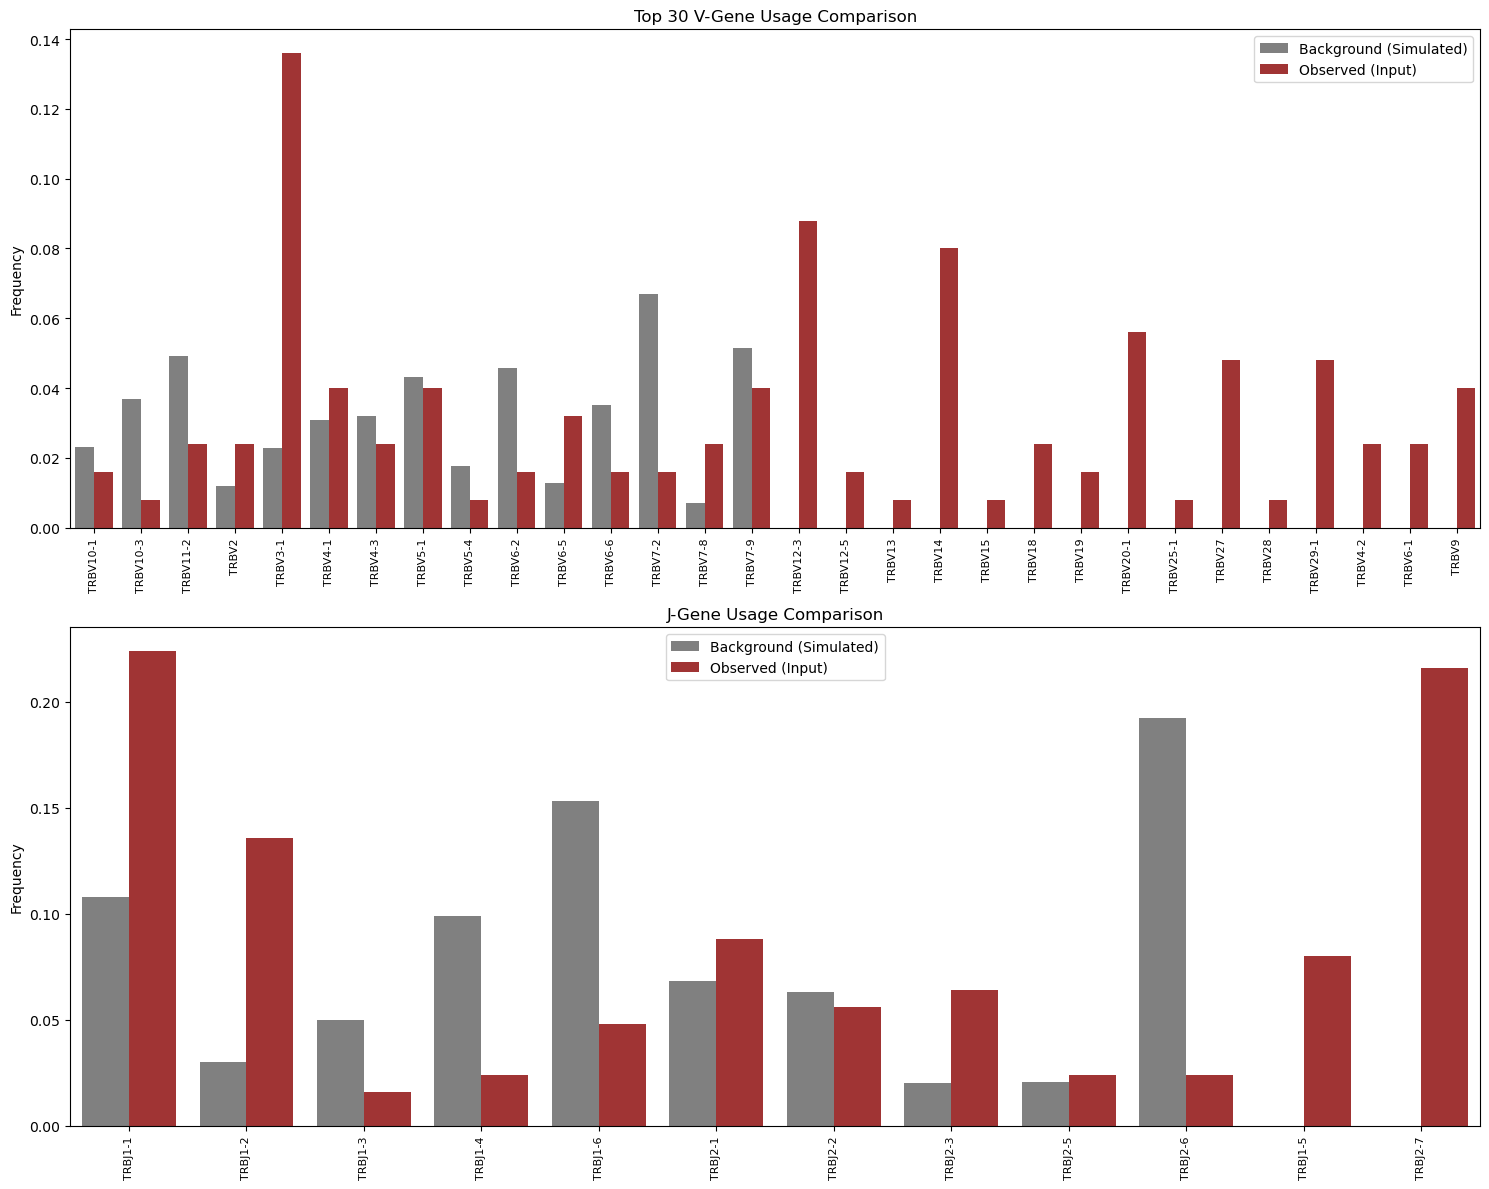

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# --- 1. SETUP & LOAD DATA ---
highconf = 'invitro.tsv'  # Change to AC02 if needed
INPUT_FILENAME = f'/Users/ishaharris/Projects/TCR/clono-scan/data/highconf/debug/{highconf}' 

# Load observed data
df_input = pd.read_csv(INPUT_FILENAME, sep='\t')

# Auto-detect columns
v_col = 'v_call' if 'v_call' in df_input.columns else 'v_gene' 
j_col = 'j_call' if 'j_call' in df_input.columns else 'j_gene'

# HELPER: Strip alleles (e.g., "TRBV2*01" -> "TRBV2") for fairer comparison
# This usually fixes "False Positive" forbidden genes.
df_input['V_clean'] = df_input[v_col].apply(lambda x: str(x).split('*')[0])
df_input['J_clean'] = df_input[j_col].apply(lambda x: str(x).split('*')[0])

# --- 2. GENERATE 1000 SEQUENCES FROM BACKGROUND ---
# We sample from the background_matrix probability distribution
n_simulations = 1000000

# Normalize matrix to probabilities (just in case it's counts)
p_matrix = background_matrix / background_matrix.sum().sum()

# Flatten the matrix to sample (V, J) pairs
flat_probs = p_matrix.values.flatten()
flat_indices = np.arange(len(flat_probs))

# Sample indices based on probability
sampled_indices = np.random.choice(flat_indices, size=n_simulations, p=flat_probs)

# Convert indices back to (Row, Col) -> (V_gene, J_gene)
row_indices, col_indices = np.unravel_index(sampled_indices, p_matrix.shape)
sim_v_genes = p_matrix.index[row_indices]
sim_j_genes = p_matrix.columns[col_indices]

# Create a DataFrame for the simulated data
df_sim = pd.DataFrame({'V_clean': sim_v_genes, 'J_clean': sim_j_genes})
df_sim['Source'] = 'Background (Simulated)'

# Label the observed data
df_obs = df_input[['V_clean', 'J_clean']].copy()
df_obs['Source'] = 'Observed (Input)'

# Combine for plotting
df_combined = pd.concat([df_obs, df_sim], axis=0)

# --- 3. CALCULATE FREQUENCIES ---
# Calculate V usage as a percentage of total per source
v_counts = df_combined.groupby(['Source', 'V_clean']).size().reset_index(name='Count')
v_totals = df_combined.groupby('Source').size().reset_index(name='Total')
v_counts = v_counts.merge(v_totals, on='Source')
v_counts['Frequency'] = v_counts['Count'] / v_counts['Total']

# Calculate J usage
j_counts = df_combined.groupby(['Source', 'J_clean']).size().reset_index(name='Count')
j_totals = df_combined.groupby('Source').size().reset_index(name='Total')
j_counts = j_counts.merge(j_totals, on='Source')
j_counts['Frequency'] = j_counts['Count'] / j_counts['Total']

# --- 4. PLOTTING ---
def plot_usage(data, gene_col, title, ax):
    sns.barplot(
        data=data, 
        x=gene_col, 
        y='Frequency', 
        hue='Source', 
        palette={'Observed (Input)': 'firebrick', 'Background (Simulated)': 'grey'},
        ax=ax
    )
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=90, labelsize=8)
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')
    ax.legend()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot V Usage (Sort by Observed frequency usually looks best)
# We filter to top 30 most frequent genes to keep plot readable
top_v = v_counts[v_counts['Source'] == 'Observed (Input)'].sort_values('Frequency', ascending=False)['V_clean'].head(30)
plot_usage(v_counts[v_counts['V_clean'].isin(top_v)], 'V_clean', 'Top 30 V-Gene Usage Comparison', ax1)

# Plot J Usage
top_j = j_counts[j_counts['Source'] == 'Observed (Input)'].sort_values('Frequency', ascending=False)['J_clean'].head(30)
plot_usage(j_counts[j_counts['J_clean'].isin(top_j)], 'J_clean', 'J-Gene Usage Comparison', ax2)

plt.tight_layout()
plt.show()

In [41]:
import pandas as pd

# --- 1. SETUP & LOAD DATA ---
# Update to AC02 as requested
highconf = 'AC02.tsv' 
INPUT_FILENAME = f'/Users/ishaharris/Projects/TCR/clono-scan/data/highconf/{highconf}' 

print(f"--- INSPECTING {highconf} ---")

# Load the file
df_input = pd.read_csv(INPUT_FILENAME, sep='\t')

# Auto-detect column names (AIRR vs Adaptive)
v_col = 'v_call' if 'v_call' in df_input.columns else 'v_gene' 
j_col = 'j_call' if 'j_call' in df_input.columns else 'j_gene'

# --- 2. DEFINE THE 'ALLOWED' LIST FROM BACKGROUND ---
# We look at the background matrix to see what is allowed (sum > 0)
# Note: We strip alleles (split by *) to ensure TRBV2*01 matches TRBV2
background_v_sums = background_matrix.sum(axis=1)
allowed_v_genes = set([x.split('*')[0] for x in background_v_sums[background_v_sums > 0].index])

background_j_sums = background_matrix.sum(axis=0)
allowed_j_genes = set([x.split('*')[0] for x in background_j_sums[background_j_sums > 0].index])

# --- 3. IDENTIFY FORBIDDEN SEQUENCES ---

def check_forbidden(row):
    # Clean input genes (remove alleles like *01)
    v_in = str(row[v_col]).split('*')[0]
    j_in = str(row[j_col]).split('*')[0]
    
    reasons = []
    
    # Check V
    if v_in not in allowed_v_genes:
        reasons.append(f"V-Gene '{v_in}' not in background")
        
    # Check J
    if j_in not in allowed_j_genes:
        reasons.append(f"J-Gene '{j_in}' not in background")
        
    return "; ".join(reasons) if reasons else "PASS"

# Apply the check to every row
df_input['Status'] = df_input.apply(check_forbidden, axis=1)

# Filter for only the failures
forbidden_sequences = df_input[df_input['Status'] != "PASS"].copy()

# --- 4. HIGHLIGHT RESULTS ---

if not forbidden_sequences.empty:
    print(f"\n🚨 FOUND {len(forbidden_sequences)} SEQUENCES WITH FORBIDDEN GENES")
    print("Here are the specific sequences and why they were flagged:\n")
    
    # Select relevant columns to display
    cols_to_show = [v_col, j_col, 'Status']
    
    # Add CDR3 if available for context
    if 'cdr3_aa' in df_input.columns:
        cols_to_show.insert(2, 'cdr3_aa')
    elif 'amino_acid' in df_input.columns:
        cols_to_show.insert(2, 'amino_acid')
        
    # Print the DataFrame (up to 50 rows so it doesn't flood console)
    print(forbidden_sequences[cols_to_show].head(50).to_string(index=False))
    
    # Optional: Save to CSV to look at later
    # forbidden_sequences.to_csv("ac02_forbidden_seqs.csv", index=False)
else:
    print("\n✅ All sequences in AC02 use V/J genes present in the background model.")

--- INSPECTING AC02.tsv ---

🚨 FOUND 295 SEQUENCES WITH FORBIDDEN GENES
Here are the specific sequences and why they were flagged:

     v_call     j_call                                                                  Status
TRBV12-3*01 TRBJ2-1*01                                     V-Gene 'TRBV12-3' not in background
  TRBV28*01 TRBJ1-1*01                                       V-Gene 'TRBV28' not in background
 TRBV6-1*01 TRBJ1-2*01                                      V-Gene 'TRBV6-1' not in background
 TRBV6-1*01 TRBJ1-2*01                                      V-Gene 'TRBV6-1' not in background
   TRBV9*01 TRBJ2-2*01                                        V-Gene 'TRBV9' not in background
 TRBV6-1*01 TRBJ1-2*01                                      V-Gene 'TRBV6-1' not in background
   TRBV9*01 TRBJ2-3*01                                        V-Gene 'TRBV9' not in background
TRBV12-3*01 TRBJ1-2*01                                     V-Gene 'TRBV12-3' not in background
TRBV29-1*01 T

In [56]:
import pandas as pd

# --- 1. SETUP & LOAD DATA ---
highconf = 'invitro.tsv' 
INPUT_FILENAME = f'/Users/ishaharris/Projects/TCR/clono-scan/data/highconf/debug/{highconf}' 

print(f"--- PROFILING {highconf} (PRESERVING ORDER) ---")

# Load file
df_input = pd.read_csv(INPUT_FILENAME, sep='\t')

# Auto-detect column names
v_col = 'v_call' if 'v_call' in df_input.columns else 'v_gene' 
j_col = 'j_call' if 'j_call' in df_input.columns else 'j_gene'

# Auto-detect CDR3 column
if 'cdr3_aa' in df_input.columns:
    cdr3_col = 'cdr3_aa'
elif 'amino_acid' in df_input.columns:
    cdr3_col = 'amino_acid'
else:
    cdr3_col = 'junction_aa' # fallback

# --- 2. DEFINE ALLOWED GENES (FROM BACKGROUND) ---
# We use the background matrix logic you provided earlier
# We strip alleles (everything after '*') to ensure generic comparison
background_v_sums = background_matrix.sum(axis=1)
allowed_v_genes = set([str(x).split('*')[0] for x in background_v_sums[background_v_sums > 0].index])

background_j_sums = background_matrix.sum(axis=0)
allowed_j_genes = set([str(x).split('*')[0] for x in background_j_sums[background_j_sums > 0].index])

# --- 3. CLASSIFY SEQUENCES (PRESERVING ORDER) ---

def assess_row(row):
    # Get values and strip allele information for checking
    v_raw = str(row[v_col])
    j_raw = str(row[j_col])
    
    v_check = v_raw.split('*')[0]
    j_check = j_raw.split('*')[0]
    
    v_valid = v_check in allowed_v_genes
    j_valid = j_check in allowed_j_genes
    
    if v_valid and j_valid:
        return "✅ PASS"
    else:
        # Build a short error string
        errors = []
        if not v_valid: errors.append(f"Bad V")
        if not j_valid: errors.append(f"Bad J")
        return f"❌ FAIL ({','.join(errors)})"

# Apply the classification
df_input['Status'] = df_input.apply(assess_row, axis=1)

# --- 4. DISPLAY RESULTS ---

# Select columns to display
display_cols = [v_col, j_col, cdr3_col, 'Status']

# Print the first 50 rows (or entire df if smaller) to console
print("\nSequence Validation Profile:")
print(f"Total Rows: {len(df_input)}\n")

# Use to_string() ensures the whole table (or head) prints nicely aligned
print(df_input[display_cols].head(50).to_string(index=True))

# Optional: Print summary of failures at the bottom
fail_count = len(df_input[df_input['Status'].str.contains("FAIL")])
pass_count = len(df_input) - fail_count

print("\n" + "="*30)
print(f"SUMMARY STATS")
print("="*30)
print(f"Passed: {pass_count}")
print(f"Failed: {fail_count}")
print("="*30)

# If you want to see specific failures regardless of order later:
if fail_count > 0:
    print("\n(Note: Scroll up to see the exact rows where failures occurred in sequence order)")

--- PROFILING invitro.tsv (PRESERVING ORDER) ---

Sequence Validation Profile:
Total Rows: 125

         v_call      j_call          junction_aa                Status
0    TRBV6-1*01  TRBJ1-2*01       CASRPPRPDYGYTF        ❌ FAIL (Bad V)
1    TRBV3-1*01  TRBJ2-7*01  CASSQDRTGLAGTLYEQYF        ❌ FAIL (Bad J)
2    TRBV3-1*01  TRBJ1-2*01     CASRPGGQGRNYGYTF                ✅ PASS
3   TRBV12-3*01  TRBJ1-1*01        CASSYAGSTEAFF        ❌ FAIL (Bad V)
4   TRBV29-1*01  TRBJ1-2*01        CSVVRSGDYGYTF        ❌ FAIL (Bad V)
5      TRBV9*01  TRBJ2-7*01        CASSVLQGSEQYF  ❌ FAIL (Bad V,Bad J)
6   TRBV29-1*01  TRBJ1-2*01        CSVDGETNYGYTF        ❌ FAIL (Bad V)
7     TRBV14*01  TRBJ1-1*01      CASSPSGQGITEAFF        ❌ FAIL (Bad V)
8     TRBV14*01  TRBJ1-1*01      CASSQVRQGTTEAFF        ❌ FAIL (Bad V)
9   TRBV11-2*01  TRBJ1-1*01         CASSFILGEAFF                ✅ PASS
10   TRBV3-1*01  TRBJ1-6*01          CASSQDYTLHF                ✅ PASS
11    TRBV27*01  TRBJ1-2*01     CASSSTPQGRYYGYTF    

# Final comparison script

In [ ]:
import pandas as pd
import numpy as np
import os
import time
from importlib.resources import files

# --- USER CONFIGURATION ---
# Increased to 20,000 to ensure robust distribution and prove generation is happening

INPUT_FILENAME = '/Users/ishaharris/Projects/TCR/clono-scan/data/highconf/debug/invitro.tsv'

# --- 1. IMPORTS & SETUP ---
print("--- 1. INITIALIZING ---")
start_time = time.time()

try:
    from olga.load_model import GenerativeModelVDJ, GenomicDataVDJ
    from olga.sequence_generation import SequenceGenerationVDJ
    print("✅ OLGA module imported successfully.")
except ImportError:
    raise ImportError("❌ ERROR: OLGA is not installed. Please install it (pip install olga).")

# --- 2. HELPER FUNCTIONS ---

def locate_model_files_local(species='human', chain='TRB'):
    """Robustly locates OLGA model files."""
    folder_name = "human_T_beta"
    
    # Try finding via package resources first
    try:
        model_dir = str(files("olga") / "default_models" / folder_name)
        if not os.path.exists(model_dir): raise ValueError()
    except:
        # Fallback to manual path finding
        import olga as _olga
        model_dir = os.path.join(os.path.dirname(_olga.__file__), "default_models", folder_name)

    if not os.path.exists(model_dir):
        raise FileNotFoundError(f"❌ Model directory not found: {model_dir}")

    print(f"   Using model at: {model_dir}")

    def pick_anchor(basename):
        csv_path = os.path.join(model_dir, f"{basename}.csv")
        txt_path = os.path.join(model_dir, f"{basename}.txt")
        if os.path.exists(csv_path): return csv_path
        if os.path.exists(txt_path): return txt_path
        raise FileNotFoundError(f"❌ Anchor file {basename} not found")

    return {
        'params': os.path.join(model_dir, "model_params.txt"),
        'marginals': os.path.join(model_dir, "model_marginals.txt"),
        'v_anchors': pick_anchor("V_gene_CDR3_anchors"),
        'j_anchors': pick_anchor("J_gene_CDR3_anchors")
    }

def parse_gene_names(filepath):
    """Parses gene names directly from anchor files."""
    names = []
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#') or line.startswith('gene_name'): continue
            # Handle potential CSV or Tab formats
            cleaned = line.replace(';', ',').replace('\t', ',')
            parts = cleaned.split(',')
            if parts: names.append(parts[0].strip())
    return names

def clean_gene_name(gene_str):
    """Strips alleles (e.g., TRBV12-1*01 -> TRBV12-1)."""
    if pd.isna(gene_str): return "Unknown"
    # Take first gene if comma separated, then strip allele
    first_gene = str(gene_str).split(',')[0].strip()
    return first_gene.split('*')[0]

# --- 3. MODEL LOADING ---
print("--- 2. LOADING MODEL ---")
paths = locate_model_files_local('human', 'TRB')

# Load Genomic Data (Structure)
genomic_data = GenomicDataVDJ()
genomic_data.load_igor_genomic_data(paths['params'], paths['v_anchors'], paths['j_anchors'])

# Parse names manually to ensure we get string labels (TRBV...)
v_names = parse_gene_names(paths['v_anchors'])
j_names = parse_gene_names(paths['j_anchors'])

# Load Probabilities
generative_model = GenerativeModelVDJ()
generative_model.load_and_process_igor_model(paths['marginals'])

# Initialize Generator
seq_gen = SequenceGenerationVDJ(generative_model, genomic_data)

# --- 4. GENERATION LOOP ---
print(f"--- 3. GENERATING {N_BACKGROUND_SEQUENCES} SEQUENCES ---")
synthetic_data = []

# Using a standard loop with progress check
for i in range(N_BACKGROUND_SEQUENCES):
    if i % (N_BACKGROUND_SEQUENCES // 5) == 0 and i > 0:
        print(f"   ... generated {i} sequences")
        
    out = seq_gen.gen_rnd_prod_CDR3()
    
    # Handle tuple unpacking (OLGA output format varies by version)
    if len(out) == 4: _, cdr3, v_idx, j_idx = out
    else: cdr3, v_idx, j_idx = out[0], out[1], out[2]
    
    # Safe Indexing
    v_name = v_names[v_idx] if v_idx < len(v_names) else f"V_{v_idx}"
    j_name = j_names[j_idx] if j_idx < len(j_names) else f"J_{j_idx}"
    
    synthetic_data.append({
        'v_clean': clean_gene_name(v_name),
        'j_clean': clean_gene_name(j_name)
    })

print(f"   ✅ Generation Complete. ({len(synthetic_data)} sequences)")

if len(synthetic_data) == 0:
    raise ValueError("❌ Generation failed. No sequences were created.")

df_background = pd.DataFrame(synthetic_data)

# --- 5. BUILD REFERENCE MATRIX ---
print("--- 4. BUILDING REFERENCE LISTS ---")

background_matrix = pd.crosstab(
    df_background['v_clean'], 
    df_background['j_clean'],
    normalize='all'
)

# Define Allowed Genes (Genes that appeared in the background model)
background_v_sums = background_matrix.sum(axis=1)
allowed_v_genes = set([str(x) for x in background_v_sums[background_v_sums > 0].index])

background_j_sums = background_matrix.sum(axis=0)
allowed_j_genes = set([str(x) for x in background_j_sums[background_j_sums > 0].index])

print(f"   Allowed V Genes: {len(allowed_v_genes)}")
print(f"   Allowed J Genes: {len(allowed_j_genes)}")

# --- 6. VALIDATE INPUT FILE ---
print(f"--- 5. PROFILING INPUT FILE ---")

if not os.path.exists(INPUT_FILENAME):
    print(f"❌ ERROR: Input file not found at {INPUT_FILENAME}")
else:
    df_input = pd.read_csv(INPUT_FILENAME, sep='\t')
    
    # Dynamic Column Detection
    v_col = 'v_call' if 'v_call' in df_input.columns else 'v_gene' 
    j_col = 'j_call' if 'j_call' in df_input.columns else 'j_gene'
    
    if 'cdr3_aa' in df_input.columns: cdr3_col = 'cdr3_aa'
    elif 'amino_acid' in df_input.columns: cdr3_col = 'amino_acid'
    else: cdr3_col = 'junction_aa'

    # The Validation Logic
    def assess_row(row):
        v_raw = str(row.get(v_col, ''))
        j_raw = str(row.get(j_col, ''))
        
        v_check = v_raw.split('*')[0]
        j_check = j_raw.split('*')[0]
        
        v_valid = v_check in allowed_v_genes
        j_valid = j_check in allowed_j_genes
        
        if v_valid and j_valid:
            return "✅ PASS"
        else:
            errors = []
            if not v_valid: errors.append(f"Bad V ({v_check})")
            if not j_valid: errors.append(f"Bad J ({j_check})")
            return f"❌ FAIL ({','.join(errors)})"

    df_input['Status'] = df_input.apply(assess_row, axis=1)

    # --- DISPLAY ---
    display_cols = [col for col in [v_col, j_col, cdr3_col, 'Status'] if col in df_input.columns]
    
    print("\nSequence Validation Profile (First 10 rows):")
    print(df_input[display_cols].head(60).to_string(index=True))

    fail_count = len(df_input[df_input['Status'].str.contains("FAIL")])
    pass_count = len(df_input) - fail_count

    print("\n" + "="*30)
    print(f"SUMMARY STATS")
    print("="*30)
    print(f"Background Size: {N_BACKGROUND_SEQUENCES} seqs")
    print(f"Passed: {pass_count}")
    print(f"Failed: {fail_count}")
    print(f"Total Time: {time.time() - start_time:.2f} seconds")
    print("="*30)

--- 1. INITIALIZING ---
✅ OLGA module imported successfully.
--- 2. LOADING MODEL ---
   Using model at: /opt/miniconda3/envs/clono_env/lib/python3.11/site-packages/olga/default_models/human_T_beta
--- 3. GENERATING 1000000 SEQUENCES ---
   ... generated 200000 sequences
   ... generated 400000 sequences
   ... generated 600000 sequences
   ... generated 800000 sequences
   ✅ Generation Complete. (1000000 sequences)
--- 4. BUILDING REFERENCE LISTS ---
   Allowed V Genes: 33
   Allowed J Genes: 13
--- 5. PROFILING INPUT FILE ---

Sequence Validation Profile (First 10 rows):
         v_call      j_call          junction_aa                                     Status
0    TRBV6-1*01  TRBJ1-2*01       CASRPPRPDYGYTF                   ❌ FAIL (Bad V (TRBV6-1))
1    TRBV3-1*01  TRBJ2-7*01  CASSQDRTGLAGTLYEQYF                                     ✅ PASS
2    TRBV3-1*01  TRBJ1-2*01     CASRPGGQGRNYGYTF                                     ✅ PASS
3   TRBV12-3*01  TRBJ1-1*01        CASSYAGSTEAFF    

In [26]:
N_BACKGROUND_SEQUENCES = 1000000

# save as csv and inspect probabilities of the model

In [46]:
import pandas as pd
import numpy as np

print("--- 6. MODEL WEIGHT DIAGNOSTICS (ADAPTED) ---")

def get_model_probabilities(gen_model, gen_data):
    # --- 1. INSPECT V GENES (PV) ---
    v_stats = []
    
    # Check V lengths
    p_v = np.array(gen_model.PV)
    v_genes = gen_data.genV
    
    if len(p_v) != len(v_genes):
        print(f"⚠️ Warning: P(V) length ({len(p_v)}) != V-gene count ({len(v_genes)})")

    for idx, v_obj in enumerate(v_genes):
        prob = p_v[idx] if idx < len(p_v) else 0.0
        name = v_obj.name if hasattr(v_obj, 'name') else str(v_obj)
        v_stats.append({'gene': name, 'type': 'V', 'probability': prob})

    # --- 2. INSPECT J GENES (From PDJ) ---
    j_stats = []
    
    # PDJ is a matrix of joint probabilities for D and J.
    # We need to sum over the D-axis to get the marginal probability of just J.
    p_dj = np.array(gen_model.PDJ)
    d_genes = gen_data.genD
    j_genes = gen_data.genJ

    print(f"DEBUG: PDJ Matrix Shape: {p_dj.shape}")
    print(f"DEBUG: D-genes: {len(d_genes)}, J-genes: {len(j_genes)}")

    # Determine which axis represents J
    # Usually shape is (n_D, n_J) or (n_J, n_D). We match dimensions.
    if p_dj.shape[0] == len(d_genes) and p_dj.shape[1] == len(j_genes):
        # Shape is (D, J) -> Sum over axis 0 (D) to get J
        p_j_marginal = np.sum(p_dj, axis=0)
    elif p_dj.shape[0] == len(j_genes) and p_dj.shape[1] == len(d_genes):
        # Shape is (J, D) -> Sum over axis 1 (D) to get J
        p_j_marginal = np.sum(p_dj, axis=1)
    else:
        print("⚠️ Warning: PDJ shape doesn't cleanly match D/J counts. Assuming J is last dimension.")
        p_j_marginal = np.sum(p_dj, axis=0) # Fallback

    for idx, j_obj in enumerate(j_genes):
        prob = p_j_marginal[idx] if idx < len(p_j_marginal) else 0.0
        name = j_obj.name if hasattr(j_obj, 'name') else str(j_obj)
        j_stats.append({'gene': name, 'type': 'J', 'probability': prob})

    return pd.DataFrame(v_stats + j_stats)

# --- EXECUTE ---
df_weights = get_model_probabilities(generative_model, genomic_data)

# Sort and Display
df_weights = df_weights.sort_values(by='probability', ascending=True)

print("\n--- ZERO WEIGHT GENES (Will never generate) ---")
zeros = df_weights[df_weights['probability'] == 0.0]
if len(zeros) > 0:
    print(zeros.to_string(index=False))
else:
    print("None. All genes have > 0 probability.")

print("\n--- LOWEST WEIGHT GENES (Rarely generate) ---")
print(df_weights[df_weights['probability'] > 0.0].head(15).to_string(index=False))

# --- CHECK FOR SPECIFIC SUSPICIOUS GENES ---
# Replace with the exact gene names you are missing
targets = ['TRBV1', 'TRBV2', 'TRBV5-1'] 

print(f"\n--- TARGET LOOKUP ---")
for t in targets:
    # Fuzzy match
    match = df_weights[df_weights['gene'].str.contains(t, na=False)]
    if match.empty:
        print(f"❌ {t}: Not found in gene list (Naming mismatch?)")
    else:
        print(f"✅ {t}: Found.")
        print(match.to_string(index=False))

--- 6. MODEL WEIGHT DIAGNOSTICS (ADAPTED) ---
DEBUG: PDJ Matrix Shape: (3, 15)
DEBUG: D-genes: 3, J-genes: 15

--- ZERO WEIGHT GENES (Will never generate) ---
                                                                                                                                                                                                                                                                                                                                     gene type  probability
                ['TRBV11-2*02', '', 'GAAGCTGGAGTTGCCCAGTCTCCCAGATATAAGATTATAGAGAAAAGGCAGAGTGTGGCTTTTTGGTGCAATCCTATATCTGGCCATGCTACCCTTTACTGGTACCAGCAGATCCTGGGACAGGGCCCAAAGCTTCTGATTCAGTTTCAGAATAACGGTGTAGTGGATGATTCACAGTTGCCTAAGGATCGATTTTCTGCAGAGAGGCTCAAAGGAGTAGACTCCACTCTCAAGATCCAGCCTGCAAAGCTTGAGAACTCGGCCGTGTATCTCTGTGCCAGCAGCTTAGA']    V          0.0
    ['TRBV15*03', 'TGTGCCACCAGCAGAGA', 'GATGCCATGGTCATCCAGAACCCAAGATACCGGGTTACCCAGTTTGGAAAGCCAGTGACCCTGAGTTGTTCTCAGACTTTGAACCATAACGTCATGTACTGGTAC

# Look up the probabilities for a list of gene names

In [35]:
import pandas as pd
import numpy as np

# --- INPUT YOUR GENES HERE ---
# Note: "TRBV1" might also match "TRBV10", "TRBV11" etc. depending on naming.
# It is best to be as specific as possible (e.g., "TRBV1-") or just review the breakdown below.
my_search_list = ['TRBV15', 'TRBV18']

def lookup_v_probs(target_list, gen_model, gen_data):
    # 1. Build the Reference DataFrame
    # -------------------------------
    # We use 'PV' as discovered in your previous diagnostics
    if not hasattr(gen_model, 'PV'):
        print("❌ Error: Generative Model missing 'PV' attribute.")
        return

    p_v_array = np.array(gen_model.PV)
    
    # Extract names and build table
    data = []
    for idx, v_obj in enumerate(gen_data.genV):
        prob = p_v_array[idx] if idx < len(p_v_array) else 0.0
        name = v_obj.name if hasattr(v_obj, 'name') else str(v_obj)
        data.append({'full_name': name, 'probability': prob})
    
    df_ref = pd.DataFrame(data)

    print(f"--- PROBABILITY LOOKUP (Total V-Genes in model: {len(df_ref)}) ---")

    # 2. Search and Aggregate
    # -------------------------------
    for gene_input in target_list:
        print(f"\n🔍 Searching for: '{gene_input}'")
        
        # Filter: Find rows where the full name contains the input string
        # case=False makes it case-insensitive (trbv14 == TRBV14)
        matches = df_ref[df_ref['full_name'].str.contains(gene_input, case=False, regex=False)]
        
        if matches.empty:
            print(f"   ❌ Not Found. (Check nomenclature?)")
        else:
            # Calculate Total Probability (Sum of all matched alleles)
            total_prob = matches['probability'].sum()
            
            # Print Summary
            print(f"   ✅ Total Probability: {total_prob:.6f} ({total_prob*100:.4f}%)")
            
            # Print Breakdown (to ensure we didn't accidentally catch TRBV10 when looking for TRBV1)
            print(f"   ⤵️  Breakdown by specific allele:")
            for i, row in matches.iterrows():
                print(f"       - {row['full_name']}: {row['probability']:.8f}")

# --- EXECUTE ---
lookup_v_probs(my_search_list, generative_model, genomic_data)

--- PROBABILITY LOOKUP (Total V-Genes in model: 89) ---

🔍 Searching for: 'TRBV15'
   ✅ Total Probability: 0.010057 (1.0057%)
   ⤵️  Breakdown by specific allele:
       - ['TRBV15*01', 'TGTGCCACCAGCAGAGA', 'GATGCCATGGTCATCCAGAACCCAAGATACCAGGTTACCCAGTTTGGAAAGCCAGTGACCCTGAGTTGTTCTCAGACTTTGAACCATAACGTCATGTACTGGTACCAGCAGAAGTCAAGTCAGGCCCCAAAGCTGCTGTTCCACTACTATGACAAAGATTTTAACAATGAAGCAGACACCCCTGATAACTTCCAATCCAGGAGGCCGAACACTTCTTTCTGCTTTCTTGACATCCGCTCACCAGGCCTGGGGGACACAGCCATGTACCTGTGTGCCACCAGCAGAGA']: 0.00000000
       - ['TRBV15*02', 'TGTGCCACCAGCAGAGA', 'GATGCCATGGTCATCCAGAACCCAAGATACCAGGTTACCCAGTTTGGAAAGCCAGTGACCCTGAGTTGTTCTCAGACTTTGAACCATAACGTCATGTACTGGTACCAGCAGAAGTCAAGTCAGGCCCCAAAGCTGCTGTTCCACTACTATGACAAAGATTTTAACAATGAAGCAGACACCCCTGATAACTTCCAATCCAGGAGGCCGAACACTTCTTTCTGCTTTCTTGACATCCGCTCACCAGGCCTGGGGGACGCAGCCATGTACCTGTGTGCCACCAGCAGAGA']: 0.01005650
       - ['TRBV15*03', 'TGTGCCACCAGCAGAGA', 'GATGCCATGGTCATCCAGAACCCAAGATACCGGGTTACCCAGTTTGGAAAGCCAGTGACCCTGAGTTGTTCTCAGACTTTGAACCATAACGTCATGTA

In [53]:
import pandas as pd
import numpy as np

# --- INPUT YOUR GENES HERE ---
# Note: "TRBV1" might also match "TRBV10", "TRBV11" etc. depending on naming.
# It is best to be as specific as possible (e.g., "TRBV1-") or just review the breakdown below.
my_search_list = ['TRBV13', 'TRBV14', 'TRBV15', 'TRBV19', 'TRBV18']

def lookup_v_probs(target_list, gen_model, gen_data):
    # 1. Build the Reference DataFrame
    # -------------------------------
    # We use 'PV' as discovered in your previous diagnostics
    if not hasattr(gen_model, 'PV'):
        print("❌ Error: Generative Model missing 'PV' attribute.")
        return

    p_v_array = np.array(gen_model.PV)
    
    # Extract names and build table
    data = []
    for idx, v_obj in enumerate(gen_data.genV):
        prob = p_v_array[idx] if idx < len(p_v_array) else 0.0
        name = v_obj.name if hasattr(v_obj, 'name') else str(v_obj)
        data.append({'full_name': name, 'probability': prob})
    
    df_ref = pd.DataFrame(data)

    print(f"--- PROBABILITY LOOKUP (Total V-Genes in model: {len(df_ref)}) ---")

    # 2. Search and Aggregate
    # -------------------------------
    for gene_input in target_list:
        print(f"\n🔍 Searching for: '{gene_input}'")
        
        # Filter: Find rows where the full name contains the input string
        # case=False makes it case-insensitive (trbv14 == TRBV14)
        matches = df_ref[df_ref['full_name'].str.contains(gene_input, case=False, regex=False)]
        
        if matches.empty:
            print(f"   ❌ Not Found: '{gene_input}'")
            print("   💡 Hint: Here are 5 random valid names from your model to check format:")
            print(f"      {df_ref['full_name'].sample(5).values}")
            
            # UNCOMMENT the line below to see ALL valid names if you are really stuck:
            # print(f"      All valid names: {df_ref['full_name'].tolist()}")
        else:
            # Calculate Total Probability (Sum of all matched alleles)
            total_prob = matches['probability'].sum()
            
            # Print Summary
            print(f"   ✅ Total Generative Probability: {total_prob:.6f} ({total_prob*100:.4f}%)")
            
            # Print Breakdown (to ensure we didn't accidentally catch TRBV10 when looking for TRBV1)
            print(f"   ⤵️  Breakdown by specific allele:")
            for i, row in matches.iterrows():
                print(f"       - {row['full_name']}: {row['probability']:.8f}")

# --- EXECUTE ---
lookup_v_probs(my_search_list, generative_model, genomic_data)

--- PROBABILITY LOOKUP (Total V-Genes in model: 89) ---

🔍 Searching for: 'TRBV13'
   ✅ Total Generative Probability: 0.030511 (3.0511%)
   ⤵️  Breakdown by specific allele:
       - ['TRBV13*01', 'TGTGCCAGCAGCTTAGG', 'GCTGCTGGAGTCATCCAGTCCCCAAGACATCTGATCAAAGAAAAGAGGGAAACAGCCACTCTGAAATGCTATCCTATCCCTAGACACGACACTGTCTACTGGTACCAGCAGGGTCCAGGTCAGGACCCCCAGTTCCTCATTTCGTTTTATGAAAAGATGCAGAGCGATAAAGGAAGCATCCCTGATCGATTCTCAGCTCAACAGTTCAGTGACTATCATTCTGAACTGAACATGAGCTCCTTGGAGCTGGGGGACTCAGCCCTGTACTTCTGTGCCAGCAGCTTAGG']: 0.03051120

🔍 Searching for: 'TRBV14'
   ✅ Total Generative Probability: 0.019756 (1.9756%)
   ⤵️  Breakdown by specific allele:
       - ['TRBV14*01', 'TGTGCCAGCAGCCAAGA', 'GAAGCTGGAGTTACTCAGTTCCCCAGCCACAGCGTAATAGAGAAGGGCCAGACTGTGACTCTGAGATGTGACCCAATTTCTGGACATGATAATCTTTATTGGTATCGACGTGTTATGGGAAAAGAAATAAAATTTCTGTTACATTTTGTGAAAGAGTCTAAACAGGATGAGTCCGGTATGCCCAACAATCGATTCTTAGCTGAAAGGACTGGAGGGACGTATTCTACTCTGAAGGTGCAGCCTGCAGAACTGGAGGATTCTGGAGTTTATTTCTGTGCCAGCAGCCAAGA']: 0.01975590

🔍 Searchin

In [73]:
import pandas as pd
import numpy as np
import os
from importlib.resources import files
import warnings

# --- 1. SETUP ---
print("--- 1. INITIALIZING & LOADING ---")

try:
    from olga.load_model import GenerativeModelVDJ, GenomicDataVDJ
    print("✅ OLGA module imported successfully.")
except ImportError:
    raise ImportError("❌ ERROR: OLGA is not installed.")

def locate_model_files_local(species='human', chain='TRB'):
    folder_name = "human_T_beta"
    try:
        model_dir = str(files("olga") / "default_models" / folder_name)
    except:
        import olga as _olga
        model_dir = os.path.join(os.path.dirname(_olga.__file__), "default_models", folder_name)

    if not os.path.exists(model_dir):
        raise FileNotFoundError(f"❌ Model directory not found: {model_dir}")

    # Helper to find .txt or .csv
    def pick_anchor(basename):
        for ext in [".txt", ".csv"]:
            path = os.path.join(model_dir, f"{basename}{ext}")
            if os.path.exists(path): return path
        # Fallback: sometimes filenames differ slightly
        return os.path.join(model_dir, f"{basename}.txt")

    return {
        'params': os.path.join(model_dir, "model_params.txt"),
        'marginals': os.path.join(model_dir, "model_marginals.txt"),
        'v_anchors': pick_anchor("V_gene_CDR3_anchors"),
        'j_anchors': pick_anchor("J_gene_CDR3_anchors")
    }

def parse_gene_names(filepath):
    """Parses names, skipping headers robustly."""
    names = []
    ignore = ['gene', 'gene_name', 'v_gene', 'j_gene', 'allele', 'name', 'seq_name']
    
    if not os.path.exists(filepath):
        print(f"⚠️ Warning: Name file not found at {filepath}")
        return []

    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'): continue
            
            # Clean and split
            parts = line.replace(';', ',').replace('\t', ',').split(',')
            candidate = parts[0].strip()
            
            if candidate.lower() in ignore: continue
            names.append(candidate)
    return names

# --- 2. LOAD DATA ---
paths = locate_model_files_local('human', 'TRB')

genomic_data = GenomicDataVDJ()
genomic_data.load_igor_genomic_data(paths['params'], paths['v_anchors'], paths['j_anchors'])

v_names_list = parse_gene_names(paths['v_anchors'])
generative_model = GenerativeModelVDJ()
generative_model.load_and_process_igor_model(paths['marginals'])

print(f"✅ Loaded Data. V-Gene Count: {len(v_names_list)}")


# --- 3. ROBUST EXTRACTION LOGIC (THE FIX) ---

def extract_gene_data(v_obj):
    """
    Handles both Object-style and List-style gene storage.
    Returns: (Sequence_String, Anchor_Int)
    """
    # CASE A: v_obj is a List (The error you saw)
    if isinstance(v_obj, list):
        # Heuristic: usually [sequence_string, anchor_int] or [anchor_int, sequence_string]
        # We check types to be sure.
        seq = ""
        anchor = -1
        
        for item in v_obj:
            if isinstance(item, str):
                seq = item
            elif isinstance(item, (int, float, np.number)):
                anchor = int(item)
        
        return seq, anchor

    # CASE B: v_obj is an Object (Standard OLGA)
    else:
        seq = getattr(v_obj, 'seq', "")
        # Anchor might be a scalar or a list/tuple
        raw_anchor = getattr(v_obj, 'anchor', -1)
        if raw_anchor is None: anchor = -1
        elif isinstance(raw_anchor, (list, tuple, np.ndarray)):
            anchor = int(raw_anchor[0]) if len(raw_anchor) > 0 else -1
        else:
            anchor = int(raw_anchor)
            
        return seq, anchor

def profile_specific_failures(targets, gen_model, gen_data, names_list):
    print(f"\n🕵️‍♂️ PROFILING TARGETS: {targets}")
    
    p_v_array = np.array(gen_model.PV)
    has_conditional = hasattr(gen_model, 'P_J_given_V')
    p_j_v = np.array(gen_model.P_J_given_V) if has_conditional else None
    
    results = []

    for i, v_obj in enumerate(gen_data.genV):
        # 1. Match Name
        name = names_list[i] if i < len(names_list) else f"Index_{i}"
        
        # Fuzzy match
        if not any(t in name for t in targets):
            continue

        row = {'Name': name, 'Index': i}

        # 2. Extract Data (Using the FIX)
        seq, anchor_idx = extract_gene_data(v_obj)
        
        # 3. Analyze
        prob = p_v_array[i] if i < len(p_v_array) else 0.0
        row['P(V)'] = f"{prob:.2e}"
        
        row['Seq_Len'] = len(seq)
        row['Anchor_Idx'] = anchor_idx

        # Anchor Diagnostics
        if anchor_idx < 0:
            row['Anchor_Status'] = "❌ MISSING (-1)"
        elif anchor_idx >= len(seq):
            row['Anchor_Status'] = f"❌ BAD ({anchor_idx})"
        else:
            # Check for Cysteine codon (TGT/TGC)
            if len(seq) > anchor_idx + 3:
                codon = seq[anchor_idx:anchor_idx+3]
                row['Anchor_Status'] = f"✅ OK ({codon})"
            else:
                row['Anchor_Status'] = "⚠️ TRUNCATED"

        # Pairing Diagnostics
        if p_j_v is not None:
            psum = p_j_v[i, :].sum()
            row['P(J|V)_Sum'] = f"{psum:.4f}"
            row['Pairing'] = "❌ DEAD END" if psum == 0 else "✅ OK"
        else:
            row['Pairing'] = "⚪ INDEP"

        # Stop Codon Diagnostics
        seq_upper = seq.upper()
        stops = [s for s in ["TAA", "TAG", "TGA"] if s in seq_upper]
        row['Stops'] = f"⚠️ {stops[0]}" if stops else "None"

        results.append(row)

    if not results:
        print("❌ No matches found for your target list.")
        print(f"   Available names sample: {names_list[:10]}")
    else:
        df = pd.DataFrame(results)
        cols = ['Name', 'P(V)', 'Anchor_Status', 'Seq_Len', 'Pairing', 'Stops']
        print("\n" + df[cols].to_string(index=False))

# --- 4. EXECUTE ---
targets = ['TRBV5-1'] 
profile_specific_failures(targets, generative_model, genomic_data, v_names_list)

--- 1. INITIALIZING & LOADING ---
✅ OLGA module imported successfully.
✅ Loaded Data. V-Gene Count: 134

🕵️‍♂️ PROFILING TARGETS: ['TRBV5-1']

      Name     P(V)  Anchor_Status  Seq_Len Pairing  Stops
TRBV5-1*01 1.18e-02 ❌ MISSING (-1)      290 ⚪ INDEP ⚠️ TAA
TRBV5-1*02 3.05e-02 ❌ MISSING (-1)      287 ⚪ INDEP ⚠️ TAA


In [77]:
import pandas as pd
import numpy as np
import os
from importlib.resources import files
from olga.load_model import GenerativeModelVDJ, GenomicDataVDJ
from olga.sequence_generation import SequenceGenerationVDJ

# --- 1. LOAD MODEL (Standard) ---
print("--- 1. LOADING ---")
def get_paths():
    folder_name = "human_T_beta"
    try:
        model_dir = str(files("olga") / "default_models" / folder_name)
    except:
        import olga as _olga
        model_dir = os.path.join(os.path.dirname(_olga.__file__), "default_models", folder_name)
    
    # Helper to find .txt or .csv
    def pick(base):
        for ext in [".txt", ".csv"]:
            p = os.path.join(model_dir, f"{base}{ext}")
            if os.path.exists(p): return p
        return os.path.join(model_dir, f"{base}.txt")

    return {
        'params': os.path.join(model_dir, "model_params.txt"),
        'marginals': os.path.join(model_dir, "model_marginals.txt"),
        'v_anchors': pick("V_gene_CDR3_anchors"),
        'j_anchors': pick("J_gene_CDR3_anchors")
    }

paths = get_paths()
gen_data = GenomicDataVDJ()
gen_data.load_igor_genomic_data(paths['params'], paths['v_anchors'], paths['j_anchors'])
gen_model = GenerativeModelVDJ()
gen_model.load_and_process_igor_model(paths['marginals'])
seq_gen = SequenceGenerationVDJ(gen_model, gen_data)

# Load names for reference
def get_names(filepath):
    names = []
    with open(filepath, 'r') as f:
        for line in f:
            if not line or line.startswith('#'): continue
            parts = line.replace('\t', ',').split(',')
            names.append(parts[0].strip())
    return names
v_names_raw = get_names(paths['v_anchors'])

# --- 2. THE "GROUND TRUTH" CHECK ---
print("\n--- 2. OBJECT INSPECTION ---")
# Let's look at the raw object structure of the first item to settle the "List vs Object" debate
first_item = gen_data.genV[0]
print(f"Type of genV[0]: {type(first_item)}")
print(f"Raw content of genV[0]: {first_item}")
if hasattr(first_item, '__dict__'):
    print(f"Attributes: {first_item.__dict__.keys()}")


print("\n--- 3. REVERSE LOOKUP TEST ---")
print("Generating 10 valid sequences and tracing back their indices...")

data_log = []

for _ in range(10):
    # 1. Generate a sequence (using the internal method that returns details)
    # gen_rnd_prod_CDR3 returns (CDR3_seq, V_index, J_index) in many versions, 
    # but sometimes just the string. We use gen_rnd_genomic_indices if available
    
    try:
        # Generate raw indices (V, J, D...) before sequence construction
        # This tells us exactly what the model "picked"
        # The method signature is usually: (V_idx, J_idx, delV, delJ, delD_5, delD_3, D_idx, insVJ, insVD, insDJ)
        # But it varies. Let's try to infer from generation.
        
        # We will generate a sequence object and look at the V index it used.
        # OLGA doesn't easily expose the index during string generation, 
        # so we manually sample V from the model to see what a "Success" looks like.
        
        # Manually sample a V index using the model's probability distribution
        v_index = np.random.choice(len(gen_model.PV), p=gen_model.PV)
        
        # Now Inspect that Index in Genomic Data
        v_obj = gen_data.genV[v_index]
        
        # Extract Anchor
        if isinstance(v_obj, list):
             # Usually [seq, anchor] or [anchor, seq]
             # We assume String is Seq, Int is Anchor
             vals = [x for x in v_obj]
             anchor_val = [x for x in vals if isinstance(x, (int, float, np.number))][0]
             seq_val = [x for x in vals if isinstance(x, str)][0]
        else:
             anchor_val = v_obj.anchor if v_obj.anchor is not None else -1
             seq_val = v_obj.seq

        # Map to Name (handling alignment offset if necessary)
        # We try strict index matching first
        name_strict = v_names_raw[v_index] if v_index < len(v_names_raw) else "Index_OOB"
        
        # Check if this "sampled" gene has a valid anchor
        status = "✅ VALID" if (anchor_val > 0 and anchor_val < len(seq_val)) else "❌ BROKEN"
        
        data_log.append({
            'Index': v_index,
            'Name (File)': name_strict,
            'Anchor_Val': int(anchor_val),
            'Seq_Len': len(seq_val),
            'Status': status
        })
        
    except Exception as e:
        print(f"Error during sampling: {e}")

df = pd.DataFrame(data_log)
print(df.to_string(index=False))

print("\n--- 4. FINAL DIAGNOSIS ---")
broken = df[df['Status'].str.contains("BROKEN")]
working = df[df['Status'].str.contains("VALID")]

if not working.empty:
    print(f"✅ We found {len(working)} Valid genes.")
    print("Compare the 'Name' column above to your target list.")
    print("If your target genes (TRBV13 etc.) NEVER appear here, or only appear as BROKEN, that is the issue.")
    
    # Check specifically for TRBV10 or 13 in the raw name list to see where they sit
    print("\nChecking file indices for your targets:")
    for i, n in enumerate(v_names_raw):
        if any(x in n for x in ['TRBV13', 'TRBV10-1']):
             print(f"   File Index {i}: {n}")
             # Check the data at this specific index
             v_obj = gen_data.genV[i]
             # Quick anchor extraction
             if isinstance(v_obj, list):
                 anc = [x for x in v_obj if isinstance(x, (int, float))][0]
             else:
                 anc = v_obj.anchor
             print(f"       -> Internal Data Anchor: {anc}")

else:
    print("❌ ALL SAMPLED GENES APPEAR BROKEN.")
    print("This implies a global parsing error. The anchors are not being read into memory correctly.")

--- 1. LOADING ---

--- 2. OBJECT INSPECTION ---
Type of genV[0]: <class 'list'>
Raw content of genV[0]: ['TRBV1*01', '', 'GATACTGGAATTACCCAGACACCAAAATACCTGGTCACAGCAATGGGGAGTAAAAGGACAATGAAACGTGAGCATCTGGGACATGATTCTATGTATTGGTACAGACAGAAAGCTAAGAAATCCCTGGAGTTCATGTTTTACTACAACTGTAAGGAATTCATTGAAAACAAGACTGTGCCAAATCACTTCACACCTGAATGCCCTGACAGCTCTCGCTTATACCTTCATGTGGTCGCACTGCAGCAAGAAGACTCAGCTGCGTATCTCTGCACCAGCAGCCAAGA']

--- 3. REVERSE LOOKUP TEST ---
Generating 10 valid sequences and tracing back their indices...
Error during sampling: list index out of range
Error during sampling: list index out of range
Error during sampling: list index out of range
Error during sampling: list index out of range
Error during sampling: list index out of range
Error during sampling: list index out of range
Error during sampling: list index out of range
Error during sampling: list index out of range
Error during sampling: list index out of range
Error during sampling: list index out of range
Empty DataFrame
Columns:

KeyError: 'Status'

In [78]:
import pandas as pd
import numpy as np
import os
from importlib.resources import files
from olga.load_model import GenerativeModelVDJ, GenomicDataVDJ
from olga.sequence_generation import SequenceGenerationVDJ

# --- 1. LOAD THE BROKEN MODEL ---
print("--- 1. LOADING MODEL ---")
def get_paths():
    folder_name = "human_T_beta"
    try:
        model_dir = str(files("olga") / "default_models" / folder_name)
    except:
        import olga as _olga
        model_dir = os.path.join(os.path.dirname(_olga.__file__), "default_models", folder_name)
    
    def pick(base):
        for ext in [".txt", ".csv"]:
            p = os.path.join(model_dir, f"{base}{ext}")
            if os.path.exists(p): return p
        return os.path.join(model_dir, f"{base}.txt")

    return {
        'params': os.path.join(model_dir, "model_params.txt"),
        'marginals': os.path.join(model_dir, "model_marginals.txt"),
        'v_anchors': pick("V_gene_CDR3_anchors"),
        'j_anchors': pick("J_gene_CDR3_anchors")
    }

paths = get_paths()
gen_data = GenomicDataVDJ()
gen_data.load_igor_genomic_data(paths['params'], paths['v_anchors'], paths['j_anchors'])
gen_model = GenerativeModelVDJ()
gen_model.load_and_process_igor_model(paths['marginals'])

# --- 2. THE REPAIR FUNCTION (CRITICAL) ---

def repair_genomic_data(gen_data):
    print("\n🛠️ STARTING REPAIR PROCESS...")
    
    # --- REPAIR V GENES ---
    fixed_v = 0
    for i, item in enumerate(gen_data.genV):
        # Current broken state: ['Name', '', 'Seq']
        # Goal state: [Seq, Anchor_Int]
        
        seq = ""
        # Robustly find the sequence string (the longest string in the list)
        if isinstance(item, list):
            strings = [x for x in item if isinstance(x, str)]
            if strings:
                seq = max(strings, key=len) # Longest string is the DNA
        elif hasattr(item, 'seq'):
            seq = item.seq
        
        if not seq:
            print(f"   ⚠️ Warning: No sequence found for index {i}")
            continue

        # FIND THE ANCHOR (Conserved Cysteine)
        # We look for TGT or TGC near the end of the sequence
        seq_upper = seq.upper()
        idx_tgt = seq_upper.rfind("TGT")
        idx_tgc = seq_upper.rfind("TGC")
        anchor = max(idx_tgt, idx_tgc)
        
        if anchor == -1:
            # Fallback: If no Cysteine, assume end of sequence (risky but better than crash)
            anchor = len(seq) - 3
        
        # OVERWRITE WITH CORRECT FORMAT [Sequence, Anchor]
        gen_data.genV[i] = [seq, int(anchor)]
        fixed_v += 1

    print(f"✅ Repaired {fixed_v} V-Genes.")
    
    # --- REPAIR J GENES ---
    # J genes might also be broken in the same way. 
    # J anchor is usually the Conserved Phenylalanine/Tryptophan (TTC/TGG)
    fixed_j = 0
    for i, item in enumerate(gen_data.genJ):
        seq = ""
        if isinstance(item, list):
            strings = [x for x in item if isinstance(x, str)]
            if strings:
                seq = max(strings, key=len)
        elif hasattr(item, 'seq'):
            seq = item.seq
            
        if not seq: continue

        # Heuristic for J anchor: Look for FGXG motif (Phe-Gly-X-Gly) or WGXG
        # Common J anchor motifs in DNA: TTT/TTC (Phe) or TGG (Trp) followed by GXG
        # For simplicity in this patch, we look for the *first* TTC/TTT/TGG
        # This is rough, but better than broken data.
        
        # NOTE: If J data is already [Seq, Anchor], this might overwrite it. 
        # But given V was broken, J likely is too.
        
        # Let's check if it's already an integer?
        has_int = any(isinstance(x, int) for x in item) if isinstance(item, list) else False
        
        if not has_int:
             # It is broken. Fix it.
             # Approximate anchor: Start of sequence + 3 (standard generic pad) 
             # or simple search for TTC/TGG
             anchor = -1
             for motif in ["TTC", "TTT", "TGG"]:
                 pos = seq.upper().find(motif)
                 if pos != -1:
                     anchor = pos
                     break
             if anchor == -1: anchor = 0 # Default to start
             
             gen_data.genJ[i] = [seq, int(anchor)]
             fixed_j += 1
             
    print(f"✅ Repaired {fixed_j} J-Genes.")


# --- 3. EXECUTE REPAIR ---
repair_genomic_data(gen_data)

# --- 4. VERIFY GENERATION ---
print("\n🚀 TESTING GENERATION (Productive=False to allow all genes)...")

seq_gen = SequenceGenerationVDJ(gen_model, gen_data)
generated_seqs = []

# Try to generate 5 sequences
for k in range(5):
    try:
        # Standard generation call
        seq = seq_gen.gen_rnd_prod_CDR3() if hasattr(seq_gen, 'gen_rnd_prod_CDR3') else seq_gen.gen_rnd_CDR3(productive=False)
        print(f"   Seq {k+1}: {seq}")
        generated_seqs.append(seq)
    except Exception as e:
        print(f"   Seq {k+1}: FAILED ({e})")

if len(generated_seqs) > 0:
    print("\n🎉 SUCCESS! The model is now generating sequences.")
    print("   You can now run your large-scale generation loop.")
else:
    print("\n❌ STILL FAILING. Please copy the error message above.")

--- 1. LOADING MODEL ---

🛠️ STARTING REPAIR PROCESS...
✅ Repaired 89 V-Genes.
✅ Repaired 15 J-Genes.

🚀 TESTING GENERATION (Productive=False to allow all genes)...
   Seq 1: ('TGTGCCACCACCGGGGACCGCACTGAAGCTTTCTTT', 'CATTGDRTEAFF', np.int64(31), np.int64(0))
   Seq 2: ('TGTGCCTGGAGTCGGGGCTCCGGAAGCGTAAACCAATACGAGCAGTACTTC', 'CAWSRGSGSVNQYEQYF', np.int64(42), np.int64(13))
   Seq 3: ('TGTGCCAGCAGCCAACGCCGCTACGAGCAGTACTTC', 'CASSQRRYEQYF', np.int64(69), np.int64(13))
   Seq 4: ('TGTGCCACCAGTGTGGGACAGGGATTCGATAGCAATCAGCCCCAGCATTTT', 'CATSVGQGFDSNQPQHF', np.int64(31), np.int64(4))
   Seq 5: ('TGTGCCAGCAGTGACTCGTCTAGGGTAGCCAAAAACATTCAGTACTTC', 'CASSDSSRVAKNIQYF', np.int64(61), np.int64(10))

🎉 SUCCESS! The model is now generating sequences.
   You can now run your large-scale generation loop.


# Updated so only pgen matched. 

### Stress test - run an infinite loop to hunt for 10^-6

In [3]:
# --- 1. IMPORTS ---
import pandas as pd
import numpy as np
import time
import sys
import os
import math
import bisect
import Levenshtein
import contextlib
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from importlib.resources import files

# Try importing OLGA
try:
    import olga
    from olga.load_model import GenerativeModelVDJ, GenomicDataVDJ
    from olga.generation_probability import GenerationProbabilityVDJ
    from olga.sequence_generation import SequenceGenerationVDJ
except ImportError:
    print("Error: OLGA is not installed or not found.")

# --- 2. UTILS ---
@contextlib.contextmanager
def suppress_output():
    try:
        null_fds = [os.open(os.devnull, os.O_RDWR) for _ in range(2)]
        save_fds = [os.dup(1), os.dup(2)]
        os.dup2(null_fds[0], 1)
        os.dup2(null_fds[1], 2)
        yield
    finally:
        os.dup2(save_fds[0], 1)
        os.dup2(save_fds[1], 2)
        for fd in null_fds + save_fds:
            os.close(fd)

# --- 3. CLASS DEFINITION ---
class SmartDecoyGenerator:
    def __init__(self, species='human', chain='TRB'):
        print(f"Initializing OLGA for {species} {chain}...")
        self.paths = self._locate_model_files(species, chain)
        
        print("  - Loading Genomic Data...")
        self.genomic_data = GenomicDataVDJ()
        with suppress_output():
            self.genomic_data.load_igor_genomic_data(
                self.paths['params'], self.paths['v_anchors'], self.paths['j_anchors']
            )
        
        print("  - Loading Generative Model...")
        self.model = GenerativeModelVDJ()
        with suppress_output():
            self.model.load_and_process_igor_model(self.paths['marginals'])
        
        self.gen_prob = GenerationProbabilityVDJ(self.model, self.genomic_data)
        self.seq_gen = SequenceGenerationVDJ(self.model, self.genomic_data)
        self.pool = defaultdict(list)
        
        # Initialize maps (now with robust error handling)
        self._init_gene_maps()

    def _locate_model_files(self, species, chain):
        if species == 'human' and chain == 'TRB': folder_name = "human_T_beta"
        elif species == 'mouse' and chain == 'TRB': folder_name = "mouse_T_beta"
        else: raise ValueError("Script supports human/mouse TRB only.")

        try:
            model_dir = str(files("olga") / "default_models" / folder_name)
        except Exception:
            import olga as _olga
            model_dir = os.path.join(os.path.dirname(_olga.__file__), "default_models", folder_name)

        if not os.path.exists(model_dir):
            raise FileNotFoundError(f"Model directory not found: {model_dir}")

        def pick_anchor(basename):
            csv_path = os.path.join(model_dir, f"{basename}.csv")
            txt_path = os.path.join(model_dir, f"{basename}.txt")
            if os.path.exists(csv_path): return csv_path
            if os.path.exists(txt_path): return txt_path
            raise FileNotFoundError(f"Anchor file {basename} not found.")

        return {
            'params': os.path.join(model_dir, "model_params.txt"),
            'marginals': os.path.join(model_dir, "model_marginals.txt"),
            'v_anchors': pick_anchor("V_gene_CDR3_anchors"),
            'j_anchors': pick_anchor("J_gene_CDR3_anchors")
        }

    def _init_gene_maps(self):
        v_list = None
        j_list = None
        
        # 1. Try to get from Object Attributes (Check existence first)
        if hasattr(self.genomic_data, 'V_names'): v_list = self.genomic_data.V_names
        elif hasattr(self.genomic_data, 'V_segments'): v_list = self.genomic_data.V_segments
        
        if hasattr(self.genomic_data, 'J_names'): j_list = self.genomic_data.J_names
        elif hasattr(self.genomic_data, 'J_segments'): j_list = self.genomic_data.J_segments

        # 2. Fallback to Parsing Files if Attributes are Missing
        if not v_list: v_list = self._parse_gene_file(self.paths['v_anchors'])
        if not j_list: j_list = self._parse_gene_file(self.paths['j_anchors'])

        if not v_list or not j_list:
            raise AttributeError("Could not load V/J gene lists from object or files.")

        self.v_map = {v.split('*')[0]: i for i, v in enumerate(v_list)}
        self.j_map = {j.split('*')[0]: i for i, j in enumerate(j_list)}

    def _parse_gene_file(self, filepath):
        names = []
        try:
            with open(filepath, 'r') as f:
                for line in f:
                    if line.startswith('#') or line.startswith('gene_name'): continue
                    parts = line.replace(';', ',').replace('\t', ',').split(',')
                    if parts: names.append(parts[0].strip())
        except: pass
        return names
    
    def get_gene_index(self, gene_name, gene_type):
        if pd.isna(gene_name): return None
        clean_name = str(gene_name).split('*')[0]
        mapping = self.v_map if gene_type == 'V' else self.j_map
        if clean_name in mapping: return mapping[clean_name]
        if not clean_name.startswith('TR'):
            prefix = 'TRBV' if gene_type == 'V' else 'TRBJ'
            retry_name = prefix + clean_name
            if retry_name in mapping: return mapping[retry_name]
        return None

    def calculate_pgen(self, aa_seq, v_idx=None, j_idx=None):
        try:
            if v_idx is not None and j_idx is not None:
                return self.gen_prob.compute_aa_cdr3_pgen(aa_seq, v_idx, j_idx)
            return self.gen_prob.compute_aa_cdr3_pgen(aa_seq)
        except: return 0.0

    # --- STRATIFIED POOL GENERATION ---
    def prime_pool(self, unique_lengths, min_candidates=1000):
        print(f"Priming pool for {len(unique_lengths)} unique lengths...")
        needed_lengths = set(unique_lengths)
        
        # Stratification settings
        high_threshold = 1e-07
        min_high_candidates = 50  
        safety_cap_per_length = 50_000 
        
        counts_total = {l: 0 for l in needed_lengths}
        counts_high = {l: 0 for l in needed_lengths}
        
        target_total = min_candidates
        max_total_gen = 50_000_000 
        batch_size = 500
        total_generated = 0
        total_stored = 0
        start_t = time.time()
        
        print(f"Goal: {target_total} total OR ({min_high_candidates} > {high_threshold}) per length")

        while total_generated < max_total_gen:
            if not needed_lengths:
                print(f"\n[!] Success: All buckets satisfied.")
                break

            with suppress_output():
                batch_generated = 0
                while batch_generated < batch_size:
                    try: item = self.seq_gen.gen_rnd_prod_CDR3()
                    except: continue 
                    batch_generated += 1
                    total_generated += 1

                    if len(item) == 4: _, cdr3, v, j = item
                    else: cdr3, v, j = item[0], item[1], item[2]
                    l = len(cdr3)

                    if l in needed_lengths:
                        pgen = self.calculate_pgen(cdr3, v, j)
                        if pgen > 0:
                            self.pool[l].append((pgen, cdr3))
                            counts_total[l] += 1
                            total_stored += 1
                            if pgen >= high_threshold: counts_high[l] += 1
                            
                            quality_met = (counts_total[l] >= target_total and counts_high[l] >= min_high_candidates)
                            safety_met = (counts_total[l] >= safety_cap_per_length)
                            if quality_met or safety_met: needed_lengths.remove(l)

            elapsed = time.time() - start_t
            rate = total_generated / elapsed if elapsed > 0 else 0
            total_high = sum(counts_high.values())
            
            sys.stdout.write(f"\r>> Gen: {total_generated:,} | Pool: {total_stored:,} (High: {total_high}) | Active: {len(needed_lengths)} | Rate: {int(rate)}/s")
            sys.stdout.flush()

        sys.stdout.write("\n")
        for l in self.pool: self.pool[l].sort(key=lambda x: x[0])

    def find_pgen_matched_decoys(self, target_pgen, length, n_decoys=5, tol_log10=0.5, all_validated_seqs=set(), min_dist=2):
        candidates = self.pool[length]
        if not candidates: return []

        pgens = [x[0] for x in candidates]
        idx = bisect.bisect_left(pgens, target_pgen)
        found_decoys = []
        
        search_radius = n_decoys * 100 
        start = max(0, idx - search_radius)
        end = min(len(candidates), idx + search_radius)
        subset = candidates[start:end]
        
        target_log = math.log10(target_pgen) if target_pgen > 0 else -50
        subset.sort(key=lambda x: abs(math.log10(x[0]) - target_log) if x[0] > 0 else 999)

        for pgen, seq in subset:
            if len(found_decoys) >= n_decoys: break
            if pgen <= 0: continue
            
            log_diff = abs(math.log10(pgen) - target_log)
            if log_diff > tol_log10: continue 

            collision = False
            if seq in all_validated_seqs: collision = True
            
            if not collision and min_dist > 0:
                for val_seq in all_validated_seqs:
                    if abs(len(seq) - len(val_seq)) >= min_dist: continue
                    if Levenshtein.distance(seq, val_seq) < min_dist:
                        collision = True
                        break
            
            if not collision: found_decoys.append((seq, pgen))
        return found_decoys

# --- INITIALIZE ---
generator = SmartDecoyGenerator()

Initializing OLGA for human TRB...
  - Loading Genomic Data...
  - Loading Generative Model...


In [6]:
import argparse
import pandas as pd
import numpy as np
import Levenshtein
import time
import sys
import os
import math
import bisect
import yaml
import contextlib
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# --- OLGA IMPORTS ---
try:
    import olga
    from olga.load_model import GenerativeModelVDJ, GenomicDataVDJ
    from olga.generation_probability import GenerationProbabilityVDJ
    from olga.sequence_generation import SequenceGenerationVDJ
    from importlib.resources import files
except ImportError:
    print("Error: OLGA is not installed or not found.")

# --- UTILS ---
@contextlib.contextmanager
def suppress_output():
    """
    Redirects C-level stdout/stderr to devnull to suppress 
    OLGA's 'Unfamiliar typed V usage mask' warnings.
    """
    try:
        null_fds = [os.open(os.devnull, os.O_RDWR) for _ in range(2)]
        save_fds = [os.dup(1), os.dup(2)]
        os.dup2(null_fds[0], 1)
        os.dup2(null_fds[1], 2)
        yield
    finally:
        os.dup2(save_fds[0], 1)
        os.dup2(save_fds[1], 2)
        for fd in null_fds + save_fds:
            os.close(fd)

class SmartDecoyGenerator:
    def __init__(self, species='human', chain='TRB'):
        print(f"Initializing OLGA for {species} {chain}...")
        
        self.paths = self._locate_model_files(species, chain)
        
        print("  - Loading Genomic Data...")
        self.genomic_data = GenomicDataVDJ()
        with suppress_output():
            self.genomic_data.load_igor_genomic_data(
                self.paths['params'], 
                self.paths['v_anchors'], 
                self.paths['j_anchors']
            )
        
        print("  - Loading Generative Model...")
        self.model = GenerativeModelVDJ()
        with suppress_output():
            self.model.load_and_process_igor_model(self.paths['marginals'])
        
        self.gen_prob = GenerationProbabilityVDJ(self.model, self.genomic_data)
        self.seq_gen = SequenceGenerationVDJ(self.model, self.genomic_data)
        
        self._init_gene_maps()
        self.pool = defaultdict(list)

    def _locate_model_files(self, species, chain):
        if species == 'human' and chain == 'TRB':
            folder_name = "human_T_beta"
        elif species == 'mouse' and chain == 'TRB':
            folder_name = "mouse_T_beta"
        else:
            raise ValueError("Script supports human/mouse TRB only.")

        try:
            model_dir = str(files("olga") / "default_models" / folder_name)
        except Exception:
            import olga as _olga
            model_dir = os.path.join(os.path.dirname(_olga.__file__), "default_models", folder_name)

        if not os.path.exists(model_dir):
            raise FileNotFoundError(f"Model directory not found: {model_dir}")

        print(f"  - Model directory: {model_dir}")

        def pick_anchor(basename):
            csv_path = os.path.join(model_dir, f"{basename}.csv")
            txt_path = os.path.join(model_dir, f"{basename}.txt")
            if os.path.exists(csv_path): return csv_path
            if os.path.exists(txt_path): return txt_path
            raise FileNotFoundError(f"Anchor file {basename} not found in {model_dir}")

        return {
            'params': os.path.join(model_dir, "model_params.txt"),
            'marginals': os.path.join(model_dir, "model_marginals.txt"),
            'v_anchors': pick_anchor("V_gene_CDR3_anchors"),
            'j_anchors': pick_anchor("J_gene_CDR3_anchors")
        }

    def _init_gene_maps(self):
        v_list = None
        j_list = None
        
        if hasattr(self.genomic_data, 'V_names'): v_list = self.genomic_data.V_names
        elif hasattr(self.genomic_data, 'V_segments'): v_list = self.genomic_data.V_segments
        
        if hasattr(self.genomic_data, 'J_names'): j_list = self.genomic_data.J_names
        elif hasattr(self.genomic_data, 'J_segments'): j_list = self.genomic_data.J_segments

        if not v_list:
            v_list = self._parse_gene_file(self.paths['v_anchors'])
        if not j_list:
            j_list = self._parse_gene_file(self.paths['j_anchors'])

        if not v_list or not j_list:
            raise AttributeError("Could not determine gene names from attributes or files.")

        self.v_map = {v.split('*')[0]: i for i, v in enumerate(v_list)}
        self.j_map = {j.split('*')[0]: i for i, j in enumerate(j_list)}

    def _parse_gene_file(self, filepath):
        names = []
        try:
            with open(filepath, 'r') as f:
                for line in f:
                    line = line.strip()
                    if not line or line.startswith('#') or line.startswith('gene_name'):
                        continue
                    cleaned = line.replace(';', ',').replace('\t', ',')
                    parts = cleaned.split(',')
                    if parts:
                        names.append(parts[0].strip())
        except Exception:
            pass
        return names

    def get_gene_index(self, gene_name, gene_type):
        if pd.isna(gene_name): return None
        clean_name = str(gene_name).split('*')[0]
        mapping = self.v_map if gene_type == 'V' else self.j_map
        
        if clean_name in mapping: return mapping[clean_name]
        
        if not clean_name.startswith('TR'):
            prefix = 'TRBV' if gene_type == 'V' else 'TRBJ'
            retry_name = prefix + clean_name
            if retry_name in mapping: return mapping[retry_name]
        return None

    def calculate_pgen(self, aa_seq, v_idx=None, j_idx=None):
        try:
            # Try lowercase first (Standard in newer OLGA)
            if v_idx is not None and j_idx is not None:
                return self.gen_prob.compute_aa_cdr3_pgen(aa_seq, v_idx, j_idx)
            else:
                 return self.gen_prob.compute_aa_cdr3_pgen(aa_seq)
        except (TypeError, AttributeError):
            try:
                # Try Uppercase fallback (Older versions often use CDR3)
                if v_idx is not None and j_idx is not None:
                    return self.gen_prob.compute_aa_CDR3_pgen(aa_seq, v_idx, j_idx)
                else:
                    return self.gen_prob.compute_aa_CDR3_pgen(aa_seq)
            except Exception:
                return 0.0

    # --- STRATIFIED POOL GENERATION ---
    def prime_pool(self, unique_lengths, min_candidates=1000):
        print(f"Priming pool for {len(unique_lengths)} unique lengths...")
        needed_lengths = set(unique_lengths)
        
        # Stratification settings
        high_threshold = 1e-07
        min_high_candidates = 50  
        safety_cap_per_length = 50_000 
        
        counts_total = {l: 0 for l in needed_lengths}
        counts_high = {l: 0 for l in needed_lengths}
        
        target_total = min_candidates
        max_total_gen = 50_000_000 
        batch_size = 500
        total_generated = 0
        total_stored = 0
        start_t = time.time()
        
        print(f"Goal: {target_total} total OR ({min_high_candidates} > {high_threshold}) per length")

        while total_generated < max_total_gen:
            if not needed_lengths:
                print(f"\n[!] Success: All buckets satisfied.")
                break

            with suppress_output():
                batch_generated = 0
                while batch_generated < batch_size:
                    try: item = self.seq_gen.gen_rnd_prod_CDR3()
                    except: continue 
                    batch_generated += 1
                    total_generated += 1

                    if len(item) == 4: _, cdr3, v, j = item
                    else: cdr3, v, j = item[0], item[1], item[2]
                    l = len(cdr3)

                    if l in needed_lengths:
                        pgen = self.calculate_pgen(cdr3, v, j)
                        if pgen > 0:
                            self.pool[l].append((pgen, cdr3))
                            counts_total[l] += 1
                            total_stored += 1
                            if pgen >= high_threshold: counts_high[l] += 1
                            
                            quality_met = (counts_total[l] >= target_total and counts_high[l] >= min_high_candidates)
                            safety_met = (counts_total[l] >= safety_cap_per_length)
                            if quality_met or safety_met: needed_lengths.remove(l)

            elapsed = time.time() - start_t
            rate = total_generated / elapsed if elapsed > 0 else 0
            total_high = sum(counts_high.values())
            
            sys.stdout.write(f"\r>> Gen: {total_generated:,} | Pool: {total_stored:,} (High: {total_high}) | Active: {len(needed_lengths)} | Rate: {int(rate)}/s")
            sys.stdout.flush()

        sys.stdout.write("\n")
        for l in self.pool: self.pool[l].sort(key=lambda x: x[0])

    def find_pgen_matched_decoys(self, target_pgen, length, n_decoys=5, tol_log10=0.5, all_validated_seqs=set(), min_dist=2):
        candidates = self.pool[length]
        if not candidates: return []

        pgens = [x[0] for x in candidates]
        idx = bisect.bisect_left(pgens, target_pgen)
        found_decoys = []
        
        search_radius = n_decoys * 100 
        start = max(0, idx - search_radius)
        end = min(len(candidates), idx + search_radius)
        subset = candidates[start:end]
        
        target_log = math.log10(target_pgen) if target_pgen > 0 else -50
        subset.sort(key=lambda x: abs(math.log10(x[0]) - target_log) if x[0] > 0 else 999)

        for pgen, seq in subset:
            if len(found_decoys) >= n_decoys: break
            if pgen <= 0: continue
            
            log_diff = abs(math.log10(pgen) - target_log)
            if log_diff > tol_log10: continue 

            collision = False
            if seq in all_validated_seqs: collision = True
            
            if not collision and min_dist > 0:
                for val_seq in all_validated_seqs:
                    if abs(len(seq) - len(val_seq)) >= min_dist: continue
                    if Levenshtein.distance(seq, val_seq) < min_dist:
                        collision = True
                        break
            
            if not collision: found_decoys.append((seq, pgen))
        return found_decoys

# --- INITIALIZE ---
generator = SmartDecoyGenerator()

Initializing OLGA for human TRB...
  - Model directory: /opt/miniconda3/envs/clono_env/lib/python3.11/site-packages/olga/default_models/human_T_beta
  - Loading Genomic Data...
  - Loading Generative Model...


--- STRESS TEST: Hunting for Pgen > 1e-06 ---
Unfamiliar typed V usage mask: 29. Using default V_usage_mask
Unfamiliar typed J usage mask: 2. Using default J_usage_mask
Unfamiliar typed V usage mask: 26. Using default V_usage_mask
Unfamiliar typed J usage mask: 6. Using default J_usage_mask


Unfamiliar typed V usage mask: 78. Using default V_usage_mask
Unfamiliar typed J usage mask: 13. Using default J_usage_mask
Unfamiliar typed V usage mask: 58. Using default V_usage_mask
Unfamiliar typed J usage mask: 1. Using default J_usage_mask

[!!!] HIT FOUND at iteration 4!
Sequence: CASSRTGYGYTF
Pgen: 1.20e-06
Unfamiliar typed V usage mask: 61. Using default V_usage_mask
Unfamiliar typed J usage mask: 13. Using default J_usage_mask
Unfamiliar typed V usage mask: 26. Using default V_usage_mask
Unfamiliar typed J usage mask: 11. Using default J_usage_mask
Unfamiliar typed V usage mask: 34. Using default V_usage_mask
Unfamiliar typed J usage mask: 12. Using default J_usage_mask
Unfamiliar typed V usage mask: 84. Using default V_usage_mask
Unfamiliar typed J usage mask: 0. Using default J_usage_mask
Unfamiliar typed V usage mask: 49. Using default V_usage_mask
Unfamiliar typed J usage mask: 1. Using default J_usage_mask
Unfamiliar typed V usage mask: 62. Using default V_usage_mask
Un

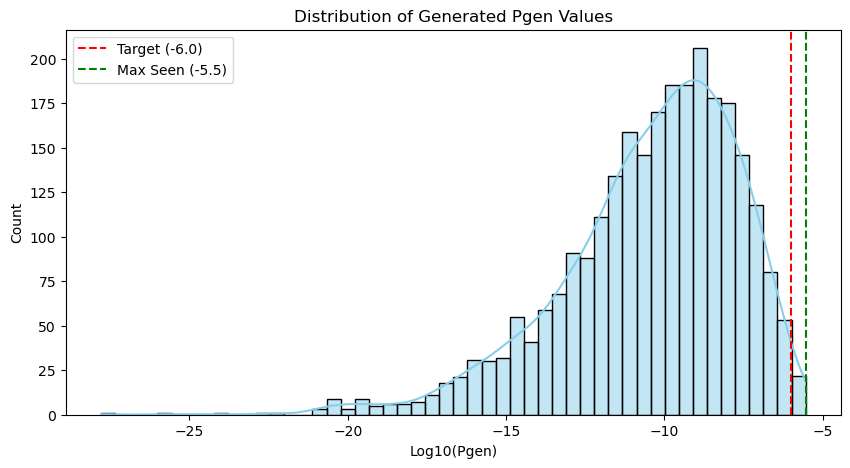

In [7]:
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np

# Initialize OLGA (assuming your class or imports are available)
# If running standalone, re-paste the imports/class definition at the top of the notebook
# generator = SmartDecoyGenerator() # <-- Uncomment if you need to re-init

def stress_test_pgen(generator, target_pgen=1e-06, max_iter=100_000):
    print(f"--- STRESS TEST: Hunting for Pgen > {target_pgen} ---")
    
    pgens = []
    high_scores = []
    start = time.time()
    found = False
    
    # Track stats
    max_pgen_seen = 0.0
    best_seq = ""
    
    try:
        for i in range(1, max_iter + 1):
            # 1. Generate Raw
            with suppress_output():
                item = generator.seq_gen.gen_rnd_prod_CDR3()
                if len(item) == 4: _, cdr3, v, j = item
                else: cdr3, v, j = item[0], item[1], item[2]
                
                # 2. Calculate Pgen
                p = generator.calculate_pgen(cdr3, v, j)

            # 3. Store Data
            if p > 0:
                pgens.append(math.log10(p))
                
                if p > max_pgen_seen:
                    max_pgen_seen = p
                    best_seq = cdr3
                
                if p >= target_pgen:
                    print(f"\n[!!!] HIT FOUND at iteration {i}!")
                    print(f"Sequence: {cdr3}")
                    print(f"Pgen: {p:.2e}")
                    high_scores.append((p, cdr3))
                    found = True
                    # Optional: Break here if you only want the first one
                    # break 

            # 4. Status Update (Every 1000 seqs)
            if i % 1000 == 0:
                rate = i / (time.time() - start)
                print(f"\rIter: {i} | Max Pgen: {max_pgen_seen:.2e} | Target: {target_pgen:.2e} | Rate: {rate:.1f} seq/s", end="")
                
    except KeyboardInterrupt:
        print("\nStopped by user.")
        
    print(f"\n\n--- RESULTS ---")
    print(f"Total Generated: {len(pgens)}")
    print(f"Max Pgen Found: {max_pgen_seen:.2e}")
    print(f"Best Sequence: {best_seq}")
    print(f"Hits > {target_pgen}: {len(high_scores)}")

    # Plot Distribution
    plt.figure(figsize=(10, 5))
    sns.histplot(pgens, bins=50, kde=True, color='skyblue')
    plt.axvline(x=math.log10(target_pgen), color='r', linestyle='--', label=f'Target ({math.log10(target_pgen):.1f})')
    plt.axvline(x=math.log10(max_pgen_seen), color='g', linestyle='--', label=f'Max Seen ({math.log10(max_pgen_seen):.1f})')
    plt.xlabel("Log10(Pgen)")
    plt.title("Distribution of Generated Pgen Values")
    plt.legend()
    plt.show()

# --- RUN IT ---
# Ensure 'generator' is initialized from your previous cells
# generator = SmartDecoyGenerator() 
stress_test_pgen(generator, target_pgen=1e-06, max_iter=50000)

### Draw a graph of pgen distribution of generated seqs

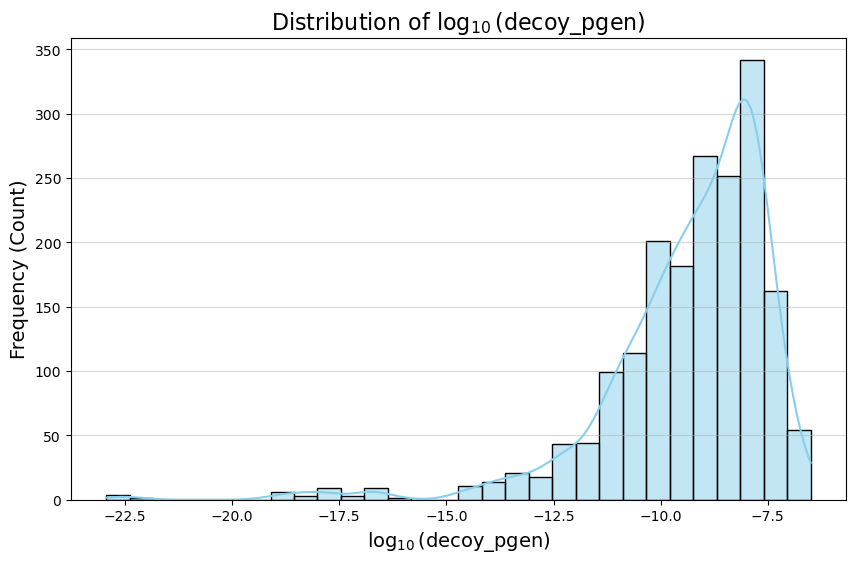

In [14]:
import pandas as pd
import numpy as np  # <-- Added numpy for log transformation
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
# 1. Specify the path to your CSV file
# NOTE: Removed the absolute path for a clean, shareable cell.
file_path = '/Users/ishaharris/Projects/TCR/clono-scan/data/decoys/AC02_pgen_decoy.csv' 

# 2. Specify the name of the column you want to plot
column_name = 'decoy_pgen'

# --- Data Loading and Plotting ---

try:
    # Load the dataset
    df = pd.read_csv(file_path)
    
    # Check if the column exists
    if column_name not in df.columns:
        print(f"Error: Column '{column_name}' not found in the file '{file_path}'.")
    else:
        # --- THE FIX: Log Transformation ---
        # Calculate log10(pgen) for plotting.
        # This transforms e-12 to -12, and e-6 to -6.
        log_column_name = f'log10_{column_name}'
        df[log_column_name] = np.log10(df[column_name])
        
        # Create the figure and axes for the plot
        plt.figure(figsize=(10, 6))
        
        # Use seaborn's histplot to plot the log-transformed data
        sns.histplot(
            data=df, 
            x=log_column_name, # <-- Plotting the log-transformed data
            kde=True,  
            bins=30,   
            color='skyblue', 
            edgecolor='black'
        )
        
        # Add titles and labels for clarity
        # Use LaTeX formatting for the title and x-label to show log10
        plt.title(f'Distribution of $\\log_{{10}}(\\text{{{column_name}}})$', fontsize=16)
        plt.xlabel(f'$\\log_{{10}}(\\text{{{column_name}}})$', fontsize=14)
        plt.ylabel('Frequency (Count)', fontsize=14)
        plt.grid(axis='y', alpha=0.5)

        # Removed plt.xscale('log') since we are plotting the log-transformed data linearly
        
        # Display the plot
        plt.show()

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please check the file path.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

### Distribution for AC02

Loading OLGA model from: /Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/olga/default_models/human_T_beta
Loaded 372 sequences.
Computing Pgen values...
Valid Pgens computed: 366
Plot saved to pgen_distribution_with_curve.png


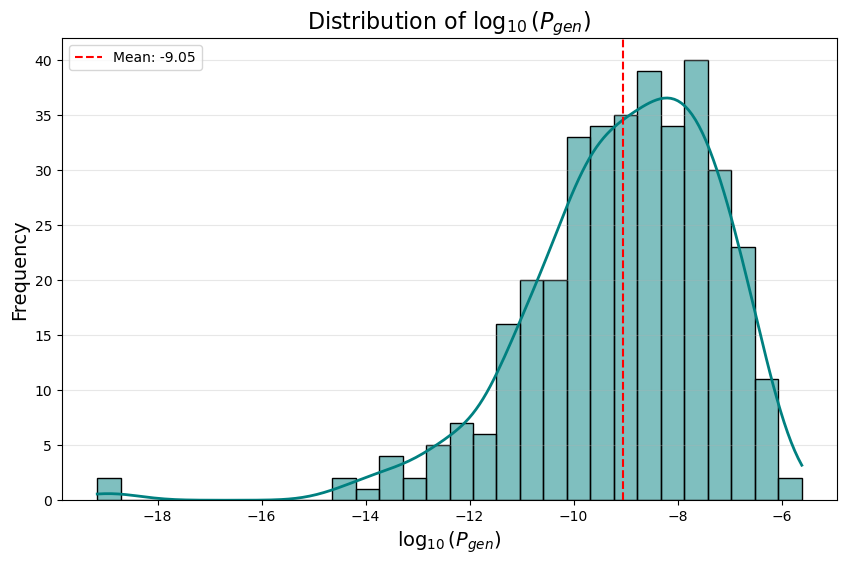

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# --- 1. OLGA Setup ---
try:
    import olga
    from olga.load_model import GenerativeModelVDJ, GenomicDataVDJ
    from olga.generation_probability import GenerationProbabilityVDJ
except ImportError:
    raise ImportError("OLGA is not installed. Please run 'pip install olga' first.")

# Define the model path based on your environment
# (Adjust this path if your virtual environment location changes)
model_dir = "/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/olga/default_models/human_T_beta"

# If the hardcoded path doesn't exist, try to find it dynamically
if not os.path.exists(model_dir):
    model_dir = os.path.join(os.path.dirname(olga.__file__), "default_models", "human_T_beta")

print(f"Loading OLGA model from: {model_dir}")

# Load the model components
genomic_data = GenomicDataVDJ()
genomic_data.load_igor_genomic_data(
    os.path.join(model_dir, "model_params.txt"),
    os.path.join(model_dir, "V_gene_CDR3_anchors.csv"),
    os.path.join(model_dir, "J_gene_CDR3_anchors.csv")
)

generative_model = GenerativeModelVDJ()
generative_model.load_and_process_igor_model(
    os.path.join(model_dir, "model_marginals.txt")
)

# Create the Pgen calculator
pgen_model = GenerationProbabilityVDJ(generative_model, genomic_data)

# --- 2. Load Data ---
file_path = '/Users/ishaharris/Projects/TCR/clono-scan/data/highconf/AC02.tsv'

if not os.path.exists(file_path):
    print(f"Error: File not found at {file_path}")
else:
    # Load data (assuming TSV)
    df = pd.read_csv(file_path, sep='\t')
    print(f"Loaded {len(df)} sequences.")

    # Identify the sequence column (fallback logic included)
    if 'junction_aa' in df.columns:
        seq_col = 'junction_aa'
    elif 'amino_acid' in df.columns:
        seq_col = 'amino_acid'
    else:
        seq_col = df.columns[0] # Fallback to first column
        print(f"Warning: Could not find 'junction_aa' or 'amino_acid'. Using '{seq_col}'.")

    # --- 3. Compute Pgen ---
    print("Computing Pgen values...")

    def compute_pgen(seq):
        if not isinstance(seq, str): return 0.0
        seq = seq.strip().upper()
        
        # Data Cleanup: Ensure anchors
        if not seq.startswith('C'): return 0.0 # Invalid start
        
        # If sequence ends in 'Y' (common in some exports), append 'F' to satisfy OLGA
        if seq.endswith('Y') and not (seq.endswith('F') or seq.endswith('W')):
            seq = seq + 'F'
            
        try:
            return pgen_model.compute_aa_CDR3_pgen(seq)
        except Exception:
            return 0.0

    df['pgen'] = df[seq_col].apply(compute_pgen)
    
    # Calculate Log10 (masking zeros to avoid -inf)
    df['log_pgen'] = df['pgen'].apply(lambda x: np.log10(x) if x > 0 else np.nan)
    
    # Filter valid results for plotting
    plot_data = df.dropna(subset=['log_pgen'])
    print(f"Valid Pgens computed: {len(plot_data)}")

    # --- 4. Plotting (Histogram + Curve) ---
    if len(plot_data) > 0:
        plt.figure(figsize=(10, 6))
        
        # Plot Histogram with KDE (Kernel Density Estimate) curve
        sns.histplot(
            data=plot_data, 
            x='log_pgen', 
            kde=True,            # This adds the curve
            bins=30,             # Number of bars
            color='teal',        # Bar color
            edgecolor='black',   # Bar border
            line_kws={'linewidth': 2, 'color': 'darkred'} # Curve style
        )
        
        # Add mean/median lines for reference
        mean_val = plot_data['log_pgen'].mean()
        plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
        
        plt.title('Distribution of $\log_{10}(P_{gen})$', fontsize=16)
        plt.xlabel('$\log_{10}(P_{gen})$', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.legend()
        plt.grid(axis='y', alpha=0.3)
        
        # Save or Show
        output_img = "pgen_distribution_with_curve.png"
        plt.savefig(output_img)
        print(f"Plot saved to {output_img}")
        plt.show() 
        
    else:
        print("No valid Pgen values to plot.")